In [1]:
from scipy.signal import welch, csd
import itertools
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# If statannot is not installed yet
# !pip install statannot

from statannot import add_stat_annotation
import scipy.stats as stats
import pandas as pd
from matplotlib.lines import Line2D

import seaborn as sns; sns.set_theme(color_codes=True)
from scipy.signal import butter, lfilter
import scipy.io
import glob

from scipy.stats import pearsonr
from scipy.stats import shapiro, mannwhitneyu
import h5py
import numpy as np
import os, stat

from scipy.signal import find_peaks
import math

import pickle
from tqdm import tqdm

from scipy.integrate import simps

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from scipy.stats import wilcoxon
import scipy.io as sio
from pprint import pprint
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from IPython.display import display, HTML

In [2]:
def cohen_d(group1, group2):
    """
    Calculate Cohen's d effect size for two groups.

    Parameters:
    group1: array-like, data of the first group.
    group2: array-like, data of the second group.

    Returns:
    float, Cohen's d effect size.
    """
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1) + np.var(group2)) / 2)
    return mean_diff / pooled_std

def plot_cohens(features, group1, group2, group3, metric, colors=["#2E8B57", "#00bfff", "#000080"], exclude_keys=None):
    """
    Creates violin plots for each feature, comparing different groups using Cohen's d effect size.

    Parameters:
    - features (dict): 
        A dictionary where keys are names for specific stages and frequency bands, and values are stored in a pandas DataFrame.
    - group1 (str): 
        Name of the first group to be compared.
    - group2 (str): 
        Name of the second group to be compared.
    - group3 (str): 
        Name of the third group to be compared.
    - metric (str): 
        Name of the metric to be analyzed (e.g., "GE").
    - colors (list of str, optional): 
        Colors for different groups. Default is ["#2E8B57", "#00bfff", "#000080"].
    - exclude_keys (list of str, optional): 
        Keys to be excluded from the calculation and display. Default is None.

    Returns:
    - Displays the violin plots and an HTML table with Cohen's d values. 
        Values can be later highlighted in bold using HTML.
    """
    # Set plot parameters
    plt.rcParams["figure.figsize"] = (8, 5)
    sns.set_palette(sns.color_palette(colors))
    sns.set(font_scale=1)
    sns.set_style(style='white')

    # Initialize empty DataFrame to store Cohen's d
    cohen_d_df = pd.DataFrame()

    # Check for excluded bands and frequencies
    if exclude_keys is None:
        exclude_keys = []

    # Create an empty DataFrame to store Cohen's d values and return a Pandas table when finished
    cohen_d_df = pd.DataFrame(columns=['Key', f'{group1}_vs_{group2}', f'{group2}_vs_{group3}', f'{group1}_vs_{group3}'])

    # Loop through the stages and frequency bands (i.e., keys)
    for key in features.keys():
        if key in exclude_keys:
            continue

        # Store features from current key
        main = features[key]

        # Subset the data for each group
        da = main[main['Class'] == group1]
        db = main[main['Class'] == group2]
        dc = main[main['Class'] == group3]

        # Calculate Cohen's d effect size for each group comparison
        d_g2_vs_g1 = cohen_d(db[metric].dropna().values, da[metric].dropna().values)
        d_g3_vs_g2 = cohen_d(dc[metric].dropna().values, db[metric].dropna().values)
        d_g3_vs_g1 = cohen_d(dc[metric].dropna().values, da[metric].dropna().values)

        # Round Cohen's d to three decimal places and add "d = " string to the annotations for display purposes
        d_g2_vs_g1_r = round(d_g2_vs_g1, 3)
        d_g3_vs_g2_r = round(d_g3_vs_g2, 3)
        d_g3_vs_g1_r = round(d_g3_vs_g1, 3)

        annot_1 = 'd = ' + str(d_g2_vs_g1_r)
        annot_2 = 'd = ' + str(d_g3_vs_g2_r)
        annot_3 = 'd = ' + str(d_g3_vs_g1_r)

        # Create violin plots
        fig, axes = plt.subplots(1, 1)
        plt.subplots_adjust(wspace=0.4)
        ax = axes

        # Order of the groups to be displayed
        order = [group1, group2, group3]

        x="Class"
        y=metric

        # Create violinplot
        sns.violinplot(ax=ax, data=main, x=x, y=y, palette=colors, order=[group1, group2, group3])

        # Add annotations
        test_results = add_stat_annotation(ax, data=main, x=x, y=y, order=order,
                                          box_pairs=[(group1, group2),(group2, group3),(group1, group3)],
                                          pvalue_format_string= '{:.3f}', comparisons_correction=None,
                                          # Display custom annotation for the Cohen's d
                                          text_annot_custom=[annot_1, annot_2, annot_3],
                                          # If not including custom annotations will perform Mann-Whitney U test
                                          test= 'Mann-Whitney', text_format='simple', loc='outside', verbose=0)

        # Create a title for the plot based on the feature and metric
        title_prefix = metric
        if key.startswith("1_"):
            title_prefix += " N2 "
            key = key[2:]
        elif key.startswith("3_"):
            title_prefix += " REM "
            key = key[2:]
        elif key.startswith("4_"):
            title_prefix += " Awake "
            key = key[2:]
        else:
            title_prefix += ""
        ax.set_title(f"{title_prefix}{key}", fontsize=14, pad=100)

        # Create dict with results for this key
        key_dict = {
            'Key': f"<b>{title_prefix}{key}</b>" if any(abs(d) >= 0.5 for d in [d_g2_vs_g1_r, d_g3_vs_g2_r, d_g3_vs_g1_r]) else f"{title_prefix}{key}",
            f'{group1}_vs_{group2}': f"<b>{d_g2_vs_g1_r}</b>" if abs(d_g2_vs_g1_r) >= 0.5 else d_g2_vs_g1_r,
            f'{group2}_vs_{group3}': f"<b>{d_g3_vs_g2_r}</b>" if abs(d_g3_vs_g2_r) >= 0.5 else d_g3_vs_g2_r,
            f'{group1}_vs_{group3}': f"<b>{d_g3_vs_g1_r}</b>" if abs(d_g3_vs_g1_r) >= 0.5 else d_g3_vs_g1_r
        }

        # Convert to DataFrame
        key_df = pd.DataFrame(key_dict, index=[0])

        # Concatenate to main DataFrame
        cohen_d_df = pd.concat([cohen_d_df, key_df])
        plt.show()

    return cohen_d_df

               
def cohens_d_channels_w_pval(group1_mats, group2_mats, channels, threshold_1=0.5, threshold_2=0.7, excluded_awake_channels=None, excluded_keys=None):
    """
    Calculate Cohen's D effect size between two groups across channels.
    Perform statistical testing using Mann-Whitney U and FDR correction.
    Plot effect size matrices annotated with significant p-values as asterisks.

    Parameters
    ----------
    group1_mats : dict
        Connectivity matrices for group 1 subjects, keyed by condition.
        Matrices have shape (n_subjects, n_channels, n_channels).
    group2_mats : dict
        Connectivity matrices for group 2 subjects, keyed by condition.
    channels : list
        Channel names corresponding to matrix indices.
    threshold_1: float, first minimum effect size considered. Default is 0.5.
    threshold_2: float, second minimum effect size considered. Default is 0.7.
    excluded_awake_channels : list, optional
        Channels to exclude for awake state.
    excluded_keys : list, optional
        Keys to exclude from analysis.

    Returns
    -------
    None

    Plots
    -----
    Cohen's D effect size matrices for each condition, with asterisks
    indicating significant connections after FDR correction.

    """
    # Set p-value Threshold
    alpha = 0.05
    # Use Benjamini-Hochberg FDR correction
    method = "fdr_bh"

    # Calculate test scores, p-values and Cohen's d for all keys
    tscore_matrices = {}
    pval_matrices = {}
    cohen_d_matrices = {}

    # Loop through stages and frequencies (i.e., keys)
    for key in group1_mats.keys():
        if key in excluded_keys:
            continue

        # Store current key data
        group1_data = np.array(group1_mats[key])
        group2_data = np.array(group2_mats[key])

        # If the key starts with '4_', exclude specified channels (e.g., Fp1 and Fp2 channels in Awake)
        if key.startswith('4_') and excluded_awake_channels is not None:
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=1)
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=2)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=1)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=2)
            
        # Initialize matrices
        matrix_size = group1_data.shape[1]
        cohen_d_matrix = np.zeros((matrix_size, matrix_size))
        tscore_matrix = np.zeros((matrix_size, matrix_size))
        pval_matrix = np.zeros((matrix_size, matrix_size))

        # Calculate test scores, Cohen's d and p-values for each matrix entry
        for i in range(matrix_size):
            for j in range(matrix_size):
                if i > j:
                    t_stat, p_val = stats.ranksums(group1_data[:, i, j], group2_data[:, i, j])
                    tscore_matrix[i, j] = t_stat
                    pval_matrix[i, j] = p_val
                    cohen_d_matrix[i, j] = cohen_d(group1_data[:, i, j], group2_data[:, i, j])

        # Make test-score matrix symmetric for visualization by adding its transpose (diagonals are zero)
        tscore_matrices[key] = tscore_matrix + tscore_matrix.T

        # Store the Cohen's D matrix for the current key and symmetrize
        cohen_d_matrices[key] = cohen_d_matrix + cohen_d_matrix.T

        # The p-value matrix is made symmetric later, after the FDR correction
        pval_matrices[key] = pval_matrix

    # Calculate FDR-corrected channel-wise p-values
    # Eliminate zero entries corresponding to the diagonal and unused triangular matrix part
    # Stack p-values for all keys (stages and bands)
    all_pvals = np.hstack([pval_matrix[pval_matrix != 0] for pval_matrix in pval_matrices.values()])

    # Replace NaN values (i.e, channels excluded in awake segments due to excesive amount of artifacts for some subjects)
    # with 1.0 before doing the FDR correction. If not replaced, NaNs would propagate in the "multipletests" toolbox.
    # By default, np.nan_to_num would replace NaNs with 0, but we want to replace them with a
    # maximal p-value of 1.0 instead so they are not counted as significant.
    all_pvals = np.nan_to_num(all_pvals, nan=1.0)
    all_corrected_pvals = multipletests(pvals=all_pvals, alpha=alpha, method=method)[1]
    print('Number of channel-wise p-values to correct = ' + str(len(all_corrected_pvals)) + '\n')

    # Create corrected p-value matrices for each key
    corrected_pval_matrices = {}
    start_idx = 0
    for key, pval_matrix in pval_matrices.items():
        matrix_size = pval_matrix.shape[0]
        corrected_pval_matrix = np.zeros((matrix_size, matrix_size))

        t = 0
        for i in range(matrix_size):
            for j in range(matrix_size):
                if i > j:
                    # Fill corrected matrix
                    corrected_pval_matrix[i, j] = all_corrected_pvals[start_idx + t]
                    t += 1
        start_idx += t
        # Make the matrix symmetric for displaying adding transpose and diagonal of ones
        # Store on the corresponding key
        corrected_pval_matrix = corrected_pval_matrix + corrected_pval_matrix.T + np.identity(matrix_size)
        corrected_pval_matrices[key] = corrected_pval_matrix

    # Set plot parameters
    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams["figure.figsize"] = [10, 10]
    linewidth = 3

    # Loop through keys to plot the Cohen's d matrix with asterisks as significant p-values
    for key in group1_mats.keys():
        if key in excluded_keys:
            continue

        # Get the matrices for each key (other matrices could be plotted if needed)
        tscore_matrix = tscore_matrices[key]
        corrected_pval_matrix = corrected_pval_matrices[key]
        uncorrected_pval_matrix = pval_matrices[key]
        cohen_d_matrix = cohen_d_matrices[key]

        # Get matrices to display averages per group
        group1_data = np.array(group1_mats[key])
        group2_data = np.array(group2_mats[key])

        # If the key starts with '4_', exclude specified channels (e.g., Fp1 and Fp2 channels in Awake)
        if key.startswith('4_') and excluded_awake_channels is not None:
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=1)
            group1_data = np.delete(group1_data, excluded_awake_channels, axis=2)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=1)
            group2_data = np.delete(group2_data, excluded_awake_channels, axis=2)
            
        # Define Cohen's d thresholds and colors
        thresholds = [threshold_1, threshold_2]
        cmap = plt.cm.coolwarm  # define the colormap
        # Extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # Create the new map
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap.N)

        # Define 5 color bins (two for negative values, two for positive, one in between +/- threshold_1.
        # Will plot one color from threshold_1 to threshold_2, 
        # and another from threshold_2 upwards (similarly for negative values)
        bounds = np.linspace(-2*threshold_2, 2*threshold_2, 5)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # Define title based on the key prefix
        if key.startswith("1_"):
            title_prefix = "N2 "
            key = key[2:]  # Remove the prefix
            current_channels = channels  # Use all channels
        elif key.startswith("3_"):
            title_prefix = "REM "
            key = key[2:]  # Remove the prefix
            current_channels = channels  # Use all channels
        elif key.startswith("4_"):
            title_prefix = "Awake "
            key = key[2:]  # Remove the prefix
            # Remove excluded awake channels for plotting
            current_channels = [ch for i, ch in enumerate(channels) if excluded_awake_channels is None or i not in excluded_awake_channels]

        else:
            title_prefix = ""

        # Mask values between -threshold_1 and threshold_1 so they are displayed white
        mask = (cohen_d_matrix >= -threshold_1) & (cohen_d_matrix <= threshold_1)
        cohen_d_matrix = np.ma.masked_array(cohen_d_matrix, mask=mask)

        # Create four plots in a row per key
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot for group 1 average
        avg_group1 = np.nanmean(group1_data, axis=0)
        im1 = axs[0].imshow(avg_group1, cmap='Reds', vmin=0, vmax=0.25)
        axs[0].set_title('Average Group 1')
        axs[0].set_xticks(list(range(len(current_channels))))
        axs[0].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[0].set_yticks(list(range(len(current_channels))))
        axs[0].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im1, ax=axs[0])

        # Plot for group 2 average
        avg_group2 = np.nanmean(group2_data, axis=0)
        im2 = axs[1].imshow(avg_group2, cmap='Reds', vmin=0, vmax=0.25)
        axs[1].set_title('Average Group 2')
        axs[1].set_xticks(list(range(len(current_channels))))
        axs[1].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[1].set_yticks(list(range(len(current_channels))))
        axs[1].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im2, ax=axs[1])

        # Plot for Cohen's D
        im3 = axs[2].imshow(cohen_d_matrix, cmap=cmap, norm=norm)
        axs[2].set_title("Cohen's D Effect Size")
        axs[2].set_xticks(list(range(len(current_channels))))
        axs[2].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[2].set_yticks(list(range(len(current_channels))))
        axs[2].set_yticklabels(current_channels, rotation=0, fontsize=12)
        # Mantain matrix sizes without showing a colorbar (a legend will be added in the manuscript figure)
        cbar = fig.colorbar(im3, ax=axs[2])
        cbar.ax.set_visible(False)

        # Plot for FDR-corrected p-values
        im4 = axs[3].imshow(corrected_pval_matrix, cmap='Greens_r', vmin=0, vmax=alpha)
        axs[3].set_title('FDR-corrected p-values')
        axs[3].set_xticks(list(range(len(current_channels))))
        axs[3].set_xticklabels(current_channels, rotation=90, fontsize=12)
        axs[3].set_yticks(list(range(len(current_channels))))
        axs[3].set_yticklabels(current_channels, rotation=0, fontsize=12)
        fig.colorbar(im4, ax=axs[3])

        fig.suptitle(f"{title_prefix}{key}", fontsize=22)
        plt.tight_layout()
        plt.show()

def plot_1st_vs_2nd_night(df, x_column, y_column, title):
    """
    Generate a scatter plot with regression line comparing two nights of EEG data.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame containing the data.
    x_column : str
        Column name for x-axis data (first night).
    y_column : str
        Column name for y-axis data (second night).
    title : str
        Plot title.

    Returns
    -------
    None

    Generates a scatter plot with regression line, including Pearson correlation
    coefficient and p-value in the legend. Compares data between two nights.

    """
    plt.rcParams["figure.figsize"] = (6, 6)
    sns.set(font_scale=2.25)
    sns.set_style(style='white')

    r, p = stats.pearsonr(df[x_column], df[y_column])

    b = sns.regplot(x=x_column, y=y_column, data=df, fit_reg=True, scatter=True, color='blue', label=str(f'$R = {r:.4f}$' + '   ' + f'$p = {p:.4f}$'))

    # Create a custom legend entry for the regression line
    custom_legend_entry = Line2D([0], [0], color='blue', linewidth=1.5, label=str(f'$R = {r:.4f}$' + '   ' + f'$p = {p:.4f}$'))

    b.axes.set_title(title, fontsize=12)
    b.set_xlabel("First night", fontsize=12)
    b.set_ylabel("Second night", fontsize=12)
    b.tick_params(labelsize=12)

    # Add the custom legend entry to the legend
    b.legend(handles=[custom_legend_entry], fontsize=12, loc='lower right')

    plt.show()

def plot_med_effects(main, group1, group2, group3, metric, alpha=0.05, colors=["#2E8B57", "#00bfff", "#000080"]):
    """
    Generate violin plot comparing 3 groups split by medication status.
    Perform Mann-Whitney U test and obtain p-values to add to the annotation.

    Parameters
    ----------
    main : DataFrame
        DataFrame containing all data.
    group1 : str
        Name of first group to compare.
    group2 : str
        Name of second group to compare.
    group3 : str
        Name of third group to compare.
    metric : str
        Column name for data to plot.
    alpha : float, optional
        Significance level for statistical test.
    colors : list, optional
        List of colors for each group.

    Returns
    -------
    None

    Generates violin plots with each group split out by medication status.
    Performs statistical testing between each pair of groups.

    """
    plt.rcParams["figure.figsize"] = (8, 5)
    sns.set_palette(sns.color_palette(colors))
    sns.set(font_scale=1)
    sns.set_style(style='white')


    # Subset the data for each group
    da = main[main['Class'] == group1]
    db = main[main['Class'] == group2]
    dc = main[main['Class'] == group3]

    # Create violin plots
    fig, axes = plt.subplots(1, 1)
    plt.subplots_adjust(wspace=0.4)
    ax = axes

    order = [group1, group2, group3]

    x="Class"
    y=metric

    sns.violinplot(ax=ax, data=main, x=x, y=y, palette=colors, order=[group1, group2, group3])
    test_results = add_stat_annotation(ax, data=main, x=x, y=y, order=order,
                                      box_pairs=[(group1, group2),(group2, group3),(group1, group3)],
                                      pvalue_format_string= '{:.3f}',
                                      test= 'Mann-Whitney', text_format='simple', loc='outside', verbose=0)

    plt.show()


# Bipolar channels
channels = ['Fp1-Fp2', 'F7-Fp1', 'F8-Fp2', 'F7-F3', 'F8-F4', 'F3-Fz', 'F4-Fz', 'C3-Cz',
            'C4-Cz', 'T3-C3', 'T4-C4', 'T5-P3', 'T6-P4', 'P3-Pz', 'P4-Pz', 'T5-O1',
            'T6-O2', 'O1-O2']

In [3]:
# Load data from previous runs
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

features = load_data('./features_v6.pickle')
metrics = load_data('./metrics_v6.pickle')
second_night = load_data('./features_2nd_night.pickle')

In [4]:
# Display features table, for example, for N2-gamma ("1_" for N2, "3_" for REM, "4_" for awake)
features['1_gamma']

Class        ID    GE_AEC    SW_AEC  Power_Front  AEC_Front_avg  \
0   ADNoEp  ADEX_026  0.052161  0.001979     0.729460       0.121856   
1   ADNoEp  ADEX_138  0.033847  0.000898     0.726588       0.052695   
2   ADNoEp  ADEX_019  0.034233  0.001059     0.741702       0.053928   
3   ADNoEp  ADEX_073  0.029915  0.000774     0.708394       0.051848   
4   ADNoEp  ADEX_102  0.060643  0.002426     0.720630       0.121541   
..     ...       ...       ...       ...          ...            ...   
84      HC  ADEX_087  0.027429  0.000710     0.707277       0.041044   
85      HC  ADEX_101  0.025684  0.000643     0.702218       0.032961   
86      HC  ADEX_070  0.031094  0.000966     0.675318       0.035136   
87      HC  ADEX_020  0.056645  0.002512     0.765013       0.099720   
88      HC  ADEX_056  0.028760  0.000819     0.711014       0.038862   

    ImCoh_Front_avg  PLI_Front_avg  wPLI_Front_avg  Power_Post  ...  \
0         -0.004138       0.073033        0.142951    0.719893  ...   
1         -0.000752       0.063928        0.100049    0.566530  ...   
2         -0.001676       0.050351        0.075046    0.698755  ...   
3         -0.001295       0.051441        0.106381    0.519091  ...   
4          0.001938       0.067182        0.095566    0.306819  ...   
..              ...            ...             ...         ...  ...   
84        -0.001477       0.052237        0.091324    0.630055  ...   
85         0.000961       0.051184        0.083689    0.701912  ...   
86         0.011109       0.064884        0.117411    0.615684  ...   
87        -0.018157       0.151578        0.240247    0.708424  ...   
88         0.000130       0.049742        0.081755    0.704789  ...   

    ImCoh_Front_Temp_avg  PLI_Front_Temp_avg  wPLI_Front_Temp_avg  \
0              -0.000896            0.065824             0.109699   
1               0.005871            0.074125             0.110404   
2               0.001055            0.052963             0.079428   
3               0.005632            0.057630             0.104489   
4               0.005547            0.067608             0.099187   
..                   ...                 ...                  ...   
84             -0.004056            0.061146             0.099182   
85             -0.000665            0.055004             0.090629   
86              0.005436            0.059934             0.097076   
87              0.009977            0.144512             0.235964   
88             -0.002926            0.058775             0.090987   

    Percentage_clean_epochs  GE_ImCoh    GE_PLI   GE_wPLI      SW_ImCoh  \
0                 84.510251 -0.000283  0.071836  0.119756  5.348434e-08   
1                 53.115727 -0.000500  0.083937  0.125654  1.412107e-09   
2                 90.909091 -0.000140  0.063421  0.095785 -7.866483e-08   
3                 85.798817 -0.000276  0.067466  0.117116  1.045147e-09   
4                 83.836590 -0.000172  0.074146  0.111600 -1.190675e-07   
..                      ...       ...       ...       ...           ...   
84                92.031873 -0.000172  0.069023  0.108788 -1.757004e-08   
85                92.771084 -0.000218  0.066401  0.111752 -4.413937e-08   
86                84.240688 -0.000496  0.068850  0.119796  5.682864e-08   
87                92.054264 -0.000752  0.131527  0.214915  4.873664e-08   
88                96.250000 -0.000272  0.065743  0.102372  4.892812e-08   

      SW_PLI   SW_wPLI  
0   0.005035  0.013003  
1   0.005411  0.012185  
2   0.003933  0.008768  
3   0.003678  0.010270  
4   0.005242  0.011585  
..       ...       ...  
84  0.004787  0.011370  
85  0.004098  0.011271  
86  0.004405  0.012248  
87  0.013478  0.036472  
88  0.004281  0.010223  

[89 rows x 31 columns]

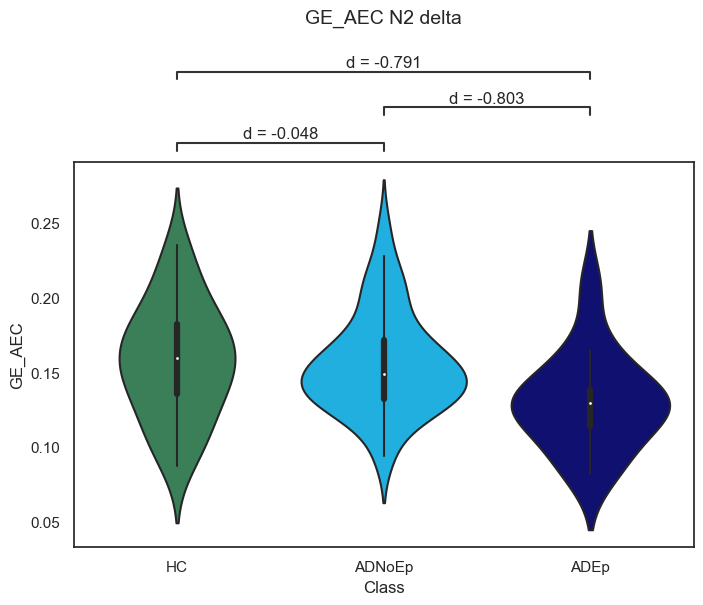

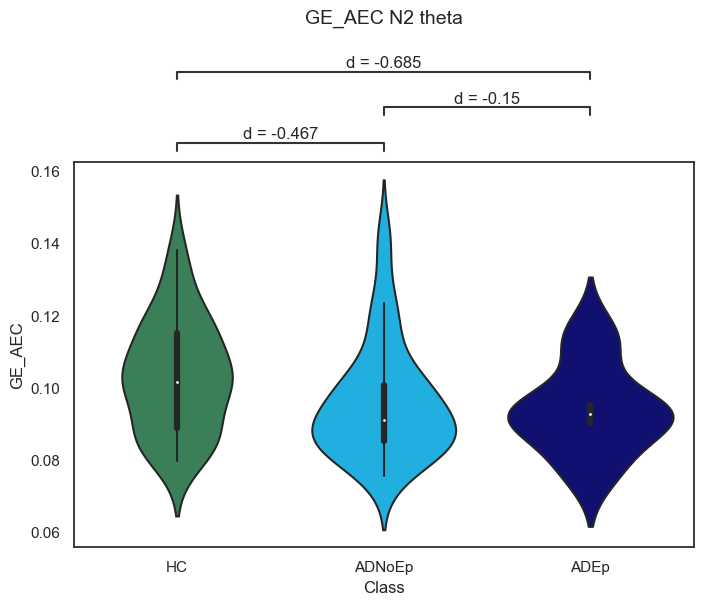

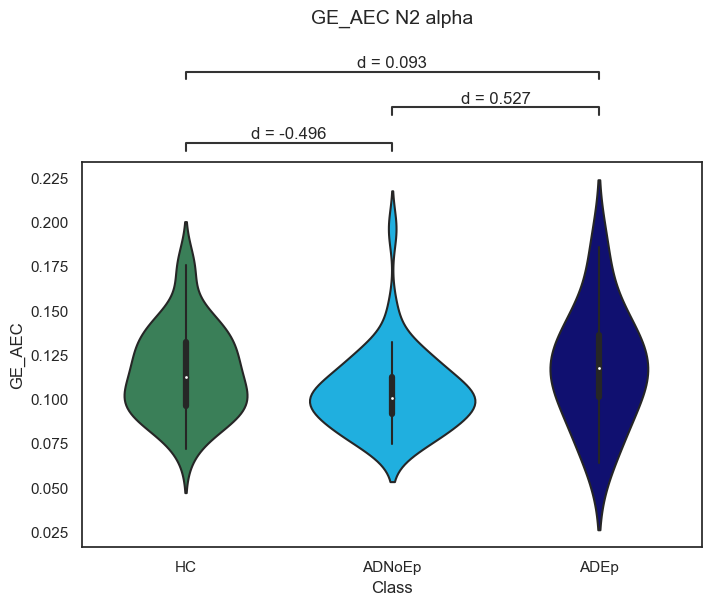

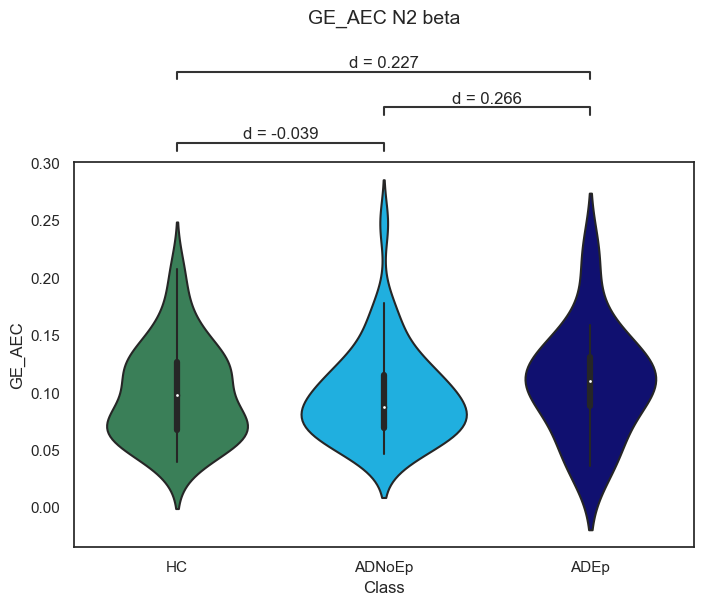

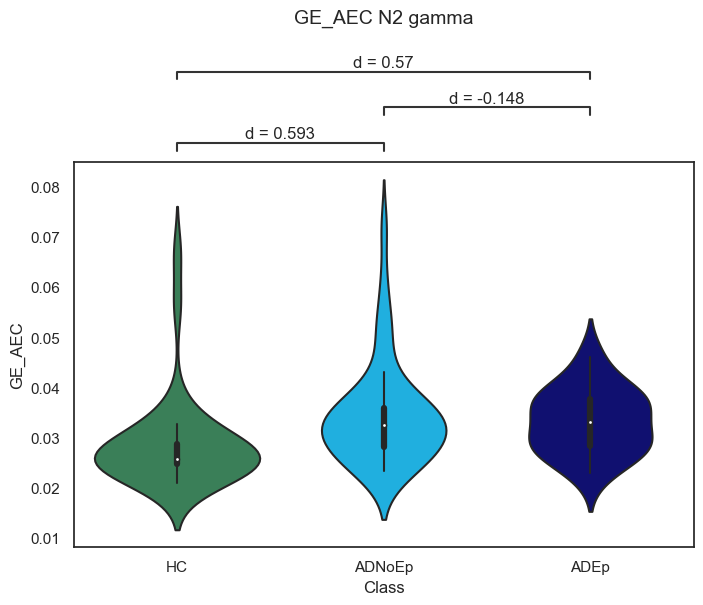

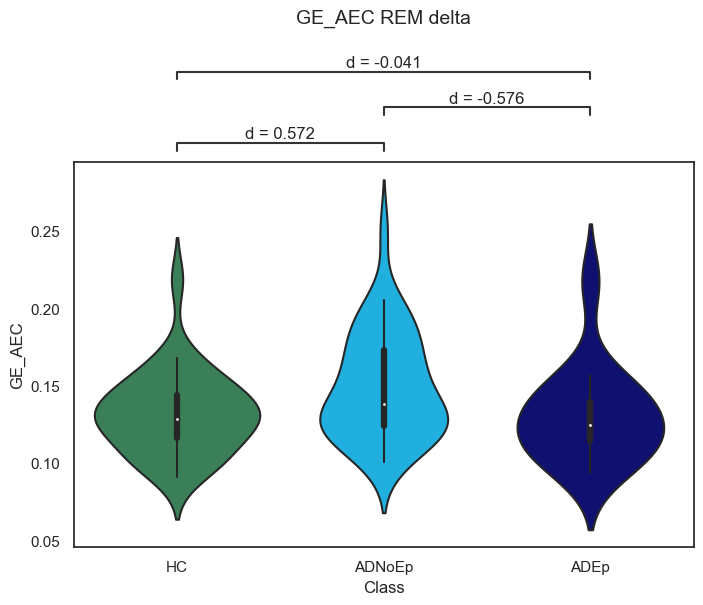

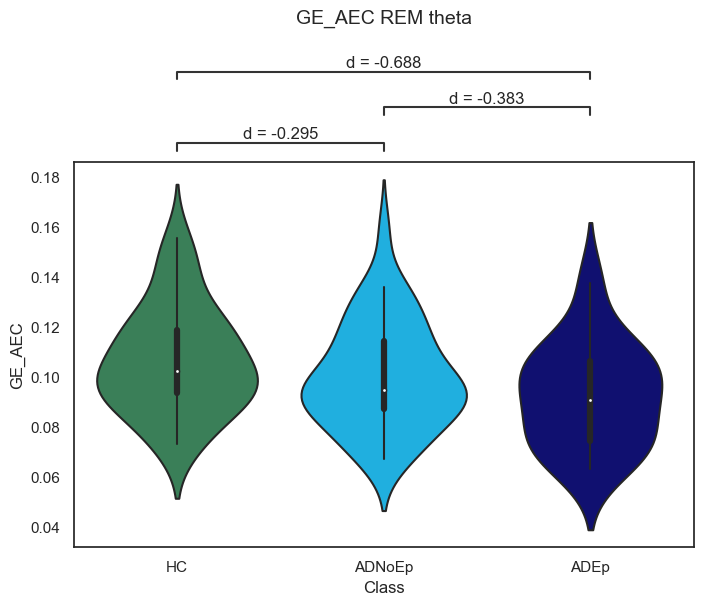

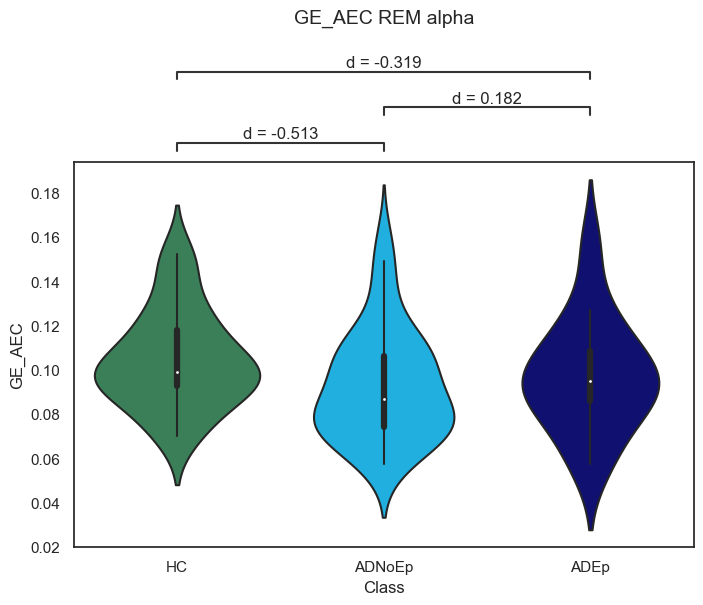

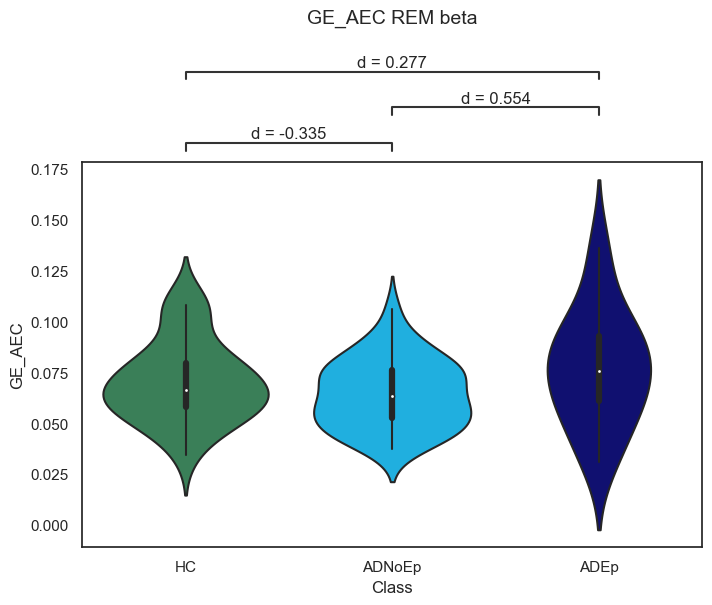

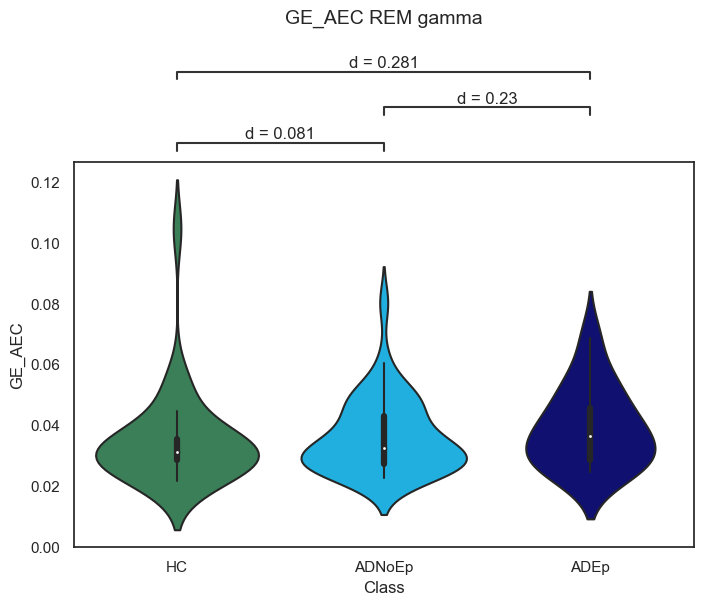

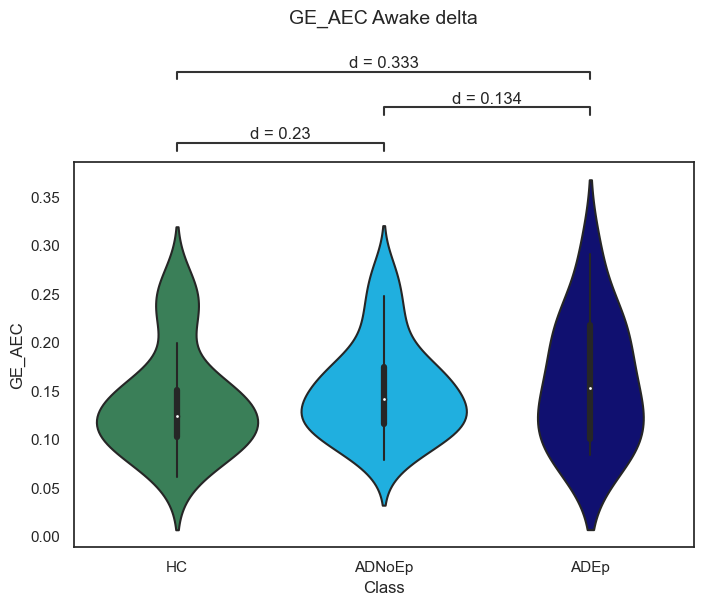

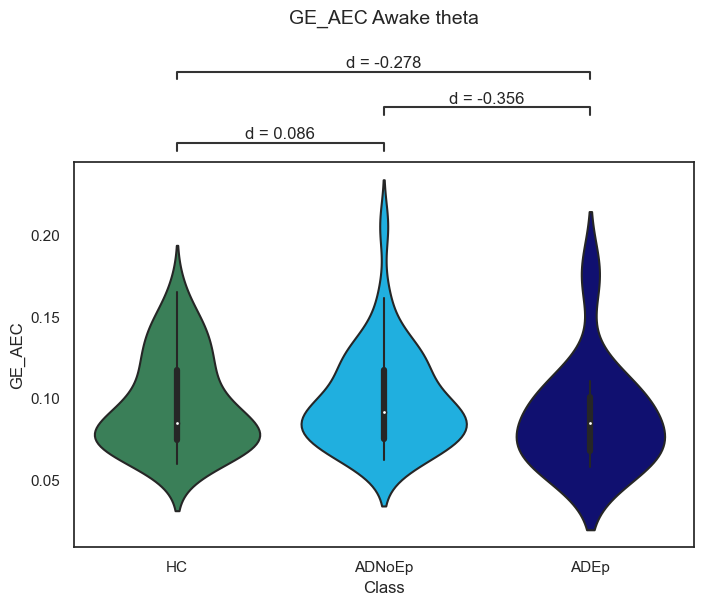

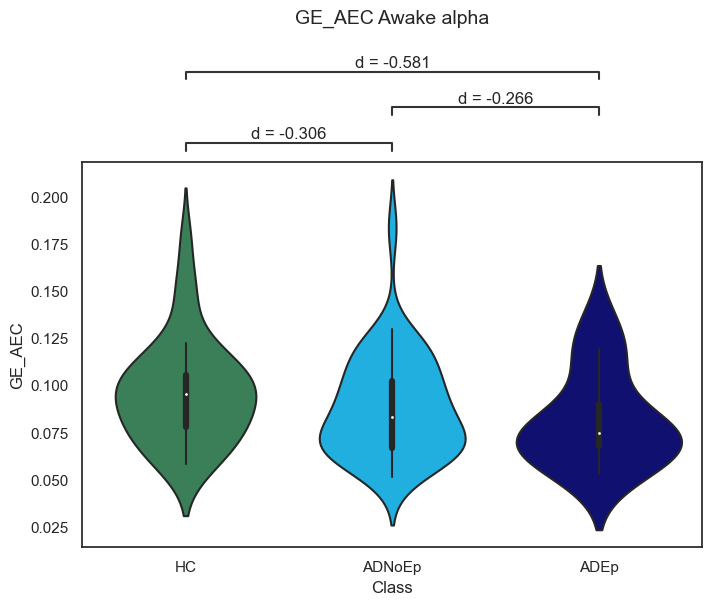

In [5]:
# Plot Cohen's d Comparing groups for GE-AEC and store in a Pandas table
features_table_ge_aec = plot_cohens(features, 'HC', 'ADNoEp', 'ADEp', 'GE_AEC', exclude_keys=["4_beta", "4_gamma"])

In [6]:
# Summarize displaying a table
# Display the dataframe with bold values (using HTML) without the index column
display(HTML(features_table_ge_aec.to_html(index=False, escape=False)))

In [7]:
# Get the 'AEC' matrices for all groups from the "metrics" data structure
adnoep_aec = {key: val['ADNoEp']['AEC'] for key, val in metrics.items()}
adep_aec = {key: val['ADEp']['AEC'] for key, val in metrics.items()}
hc_aec = {key: val['HC']['AEC'] for key, val in metrics.items()}

Number of channel-wise p-values to correct = 1845



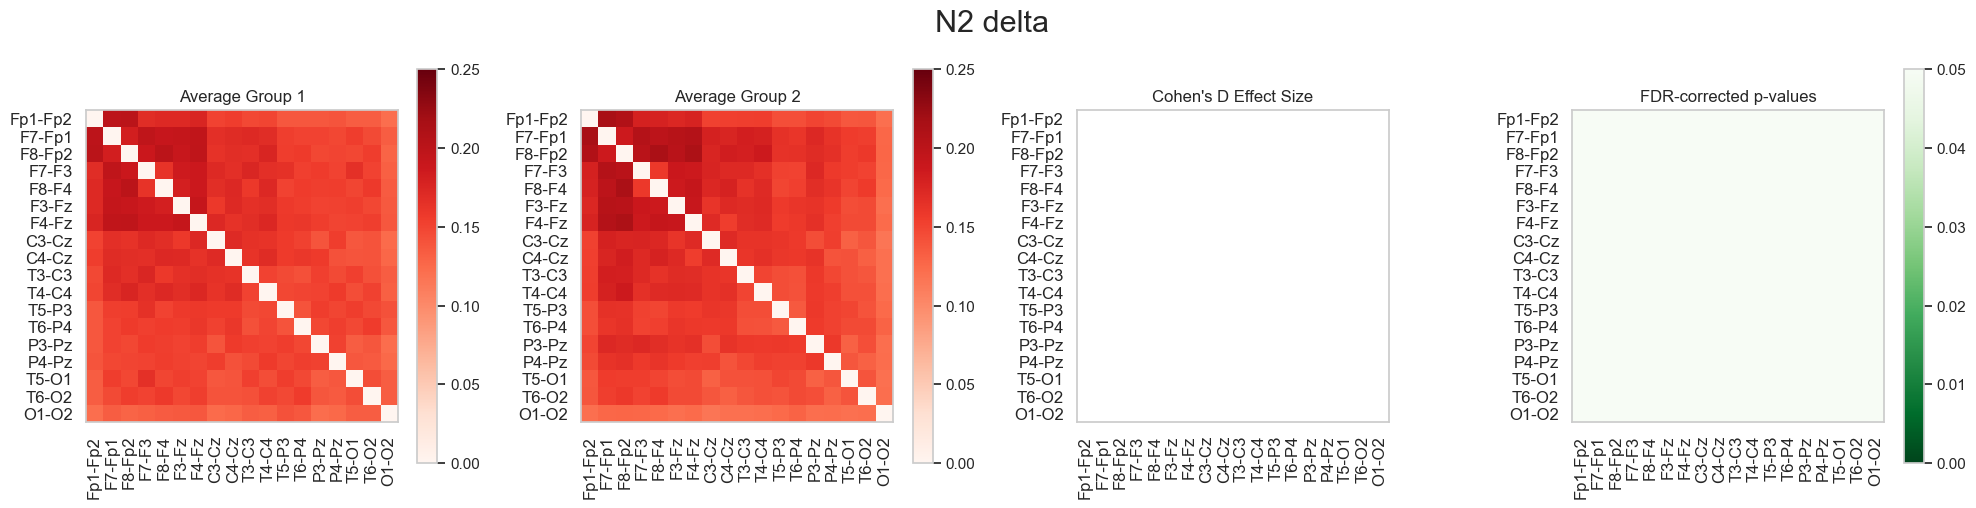

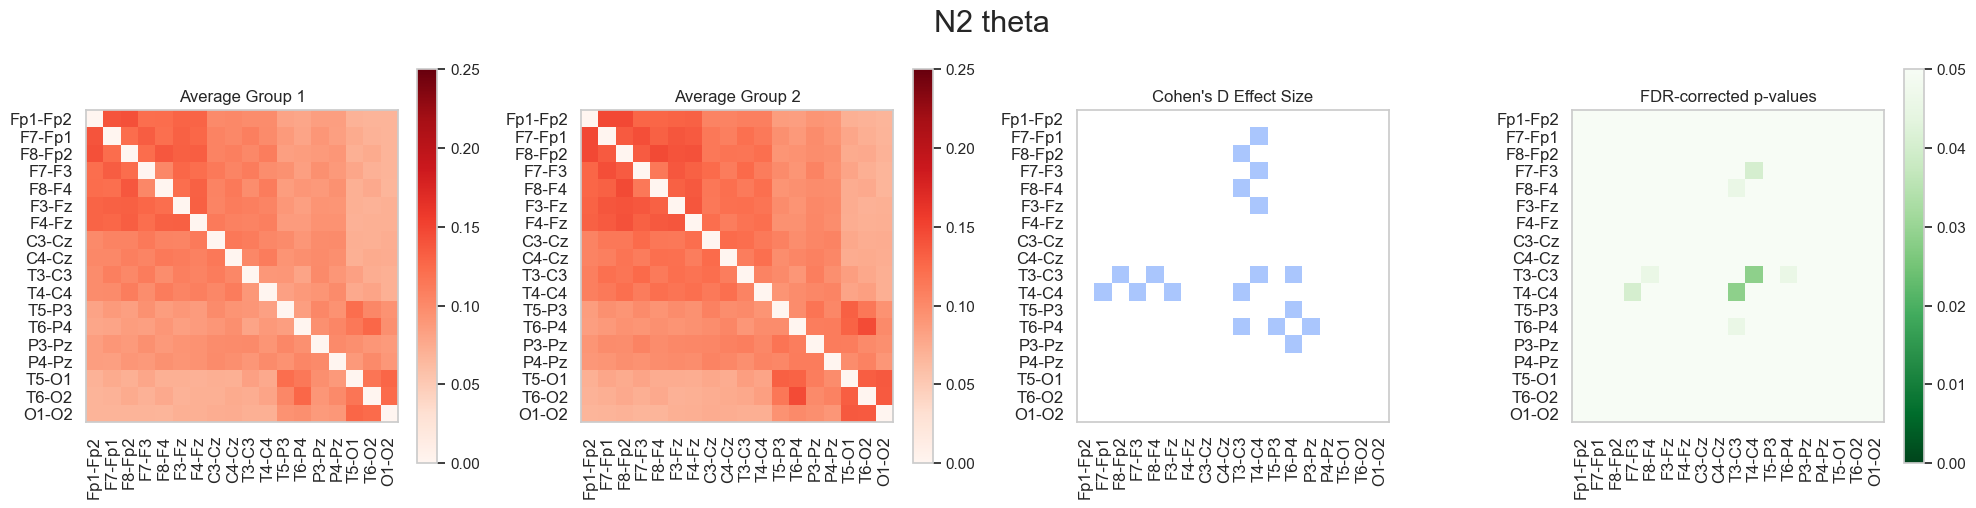

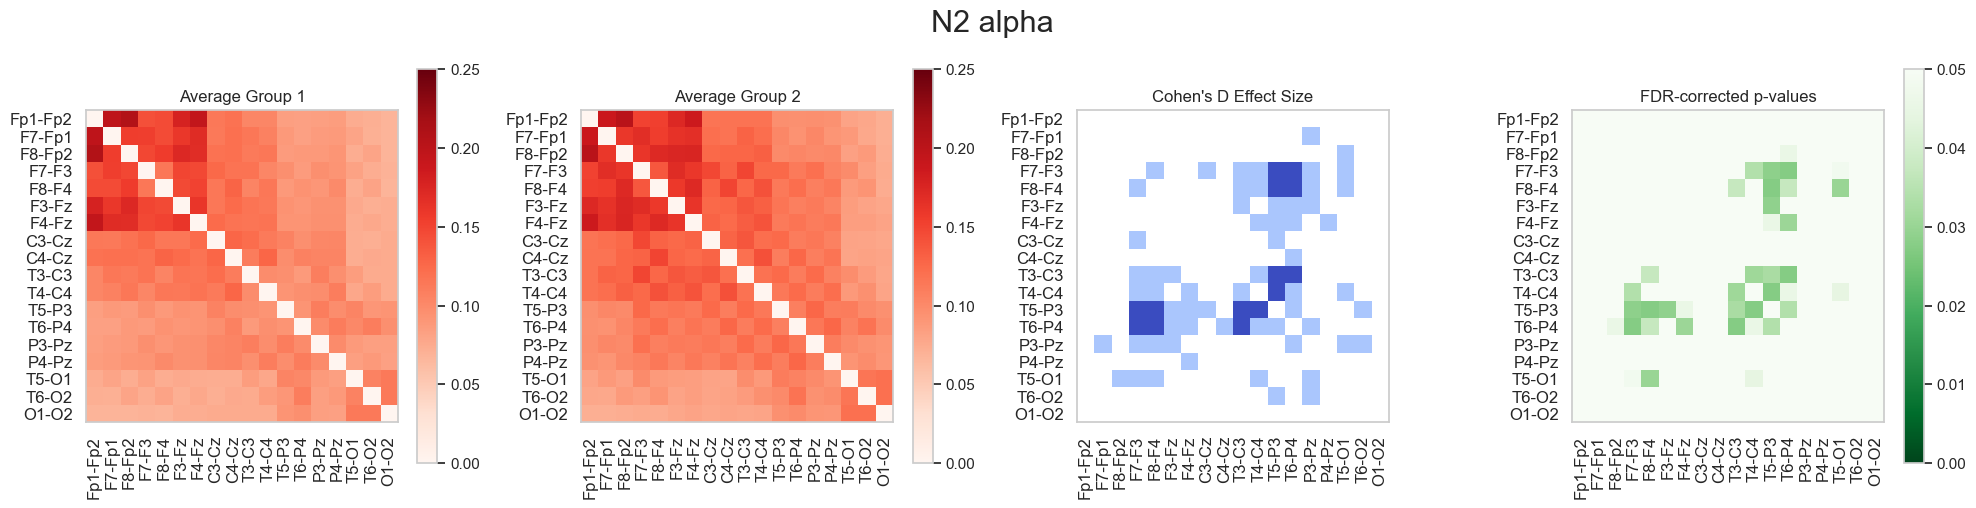

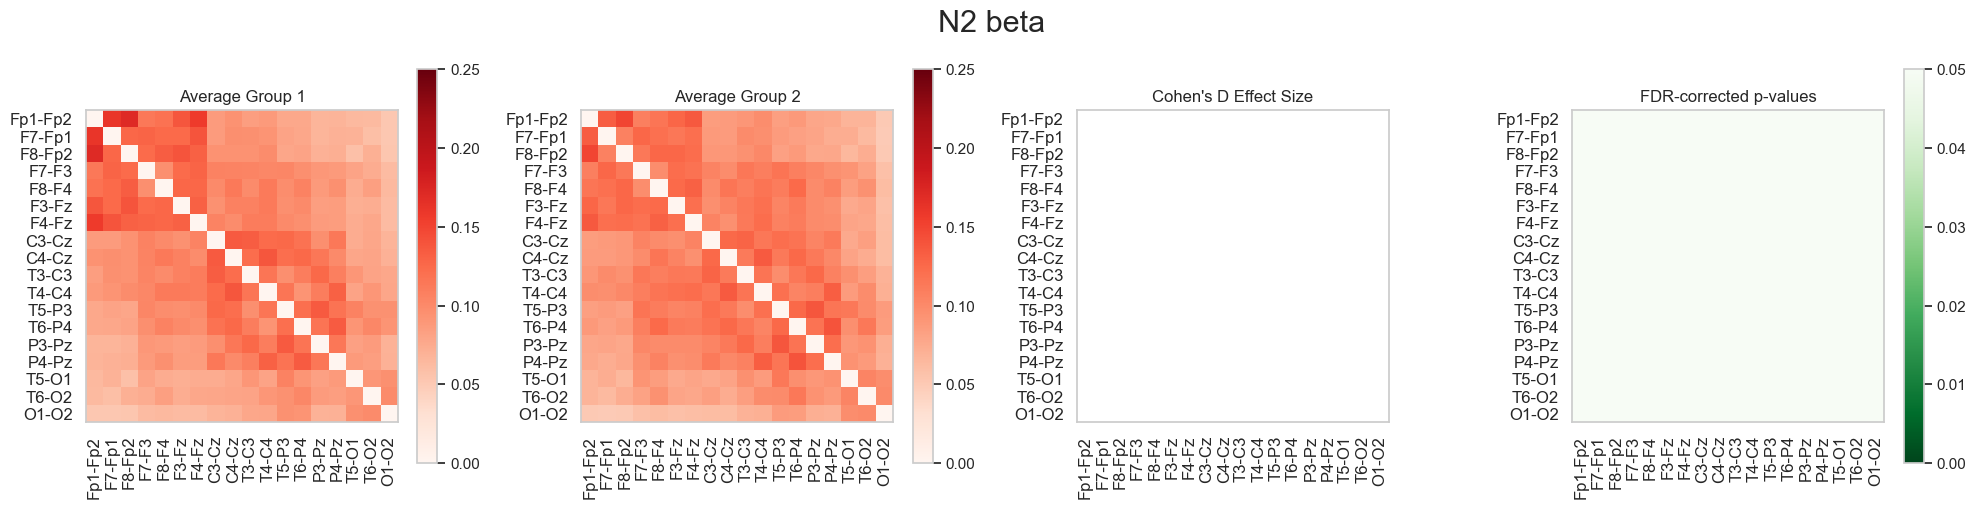

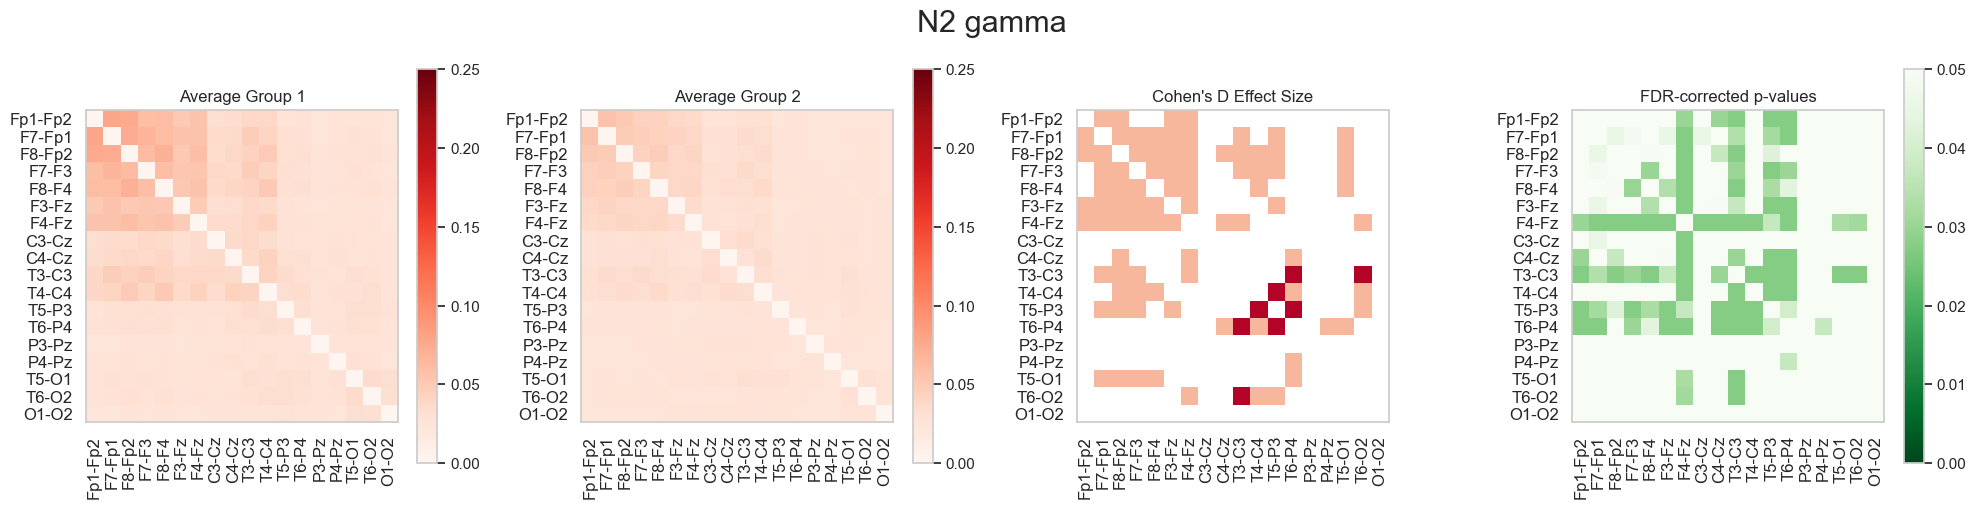

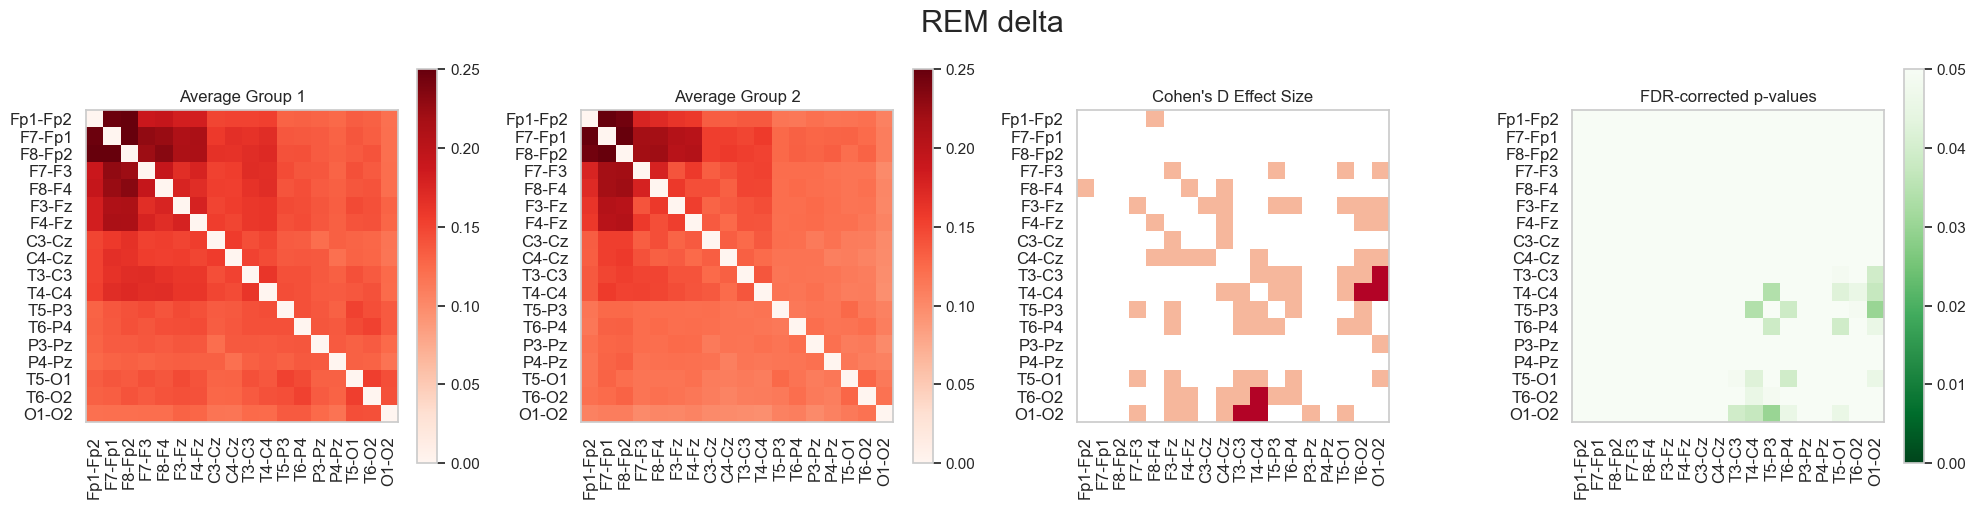

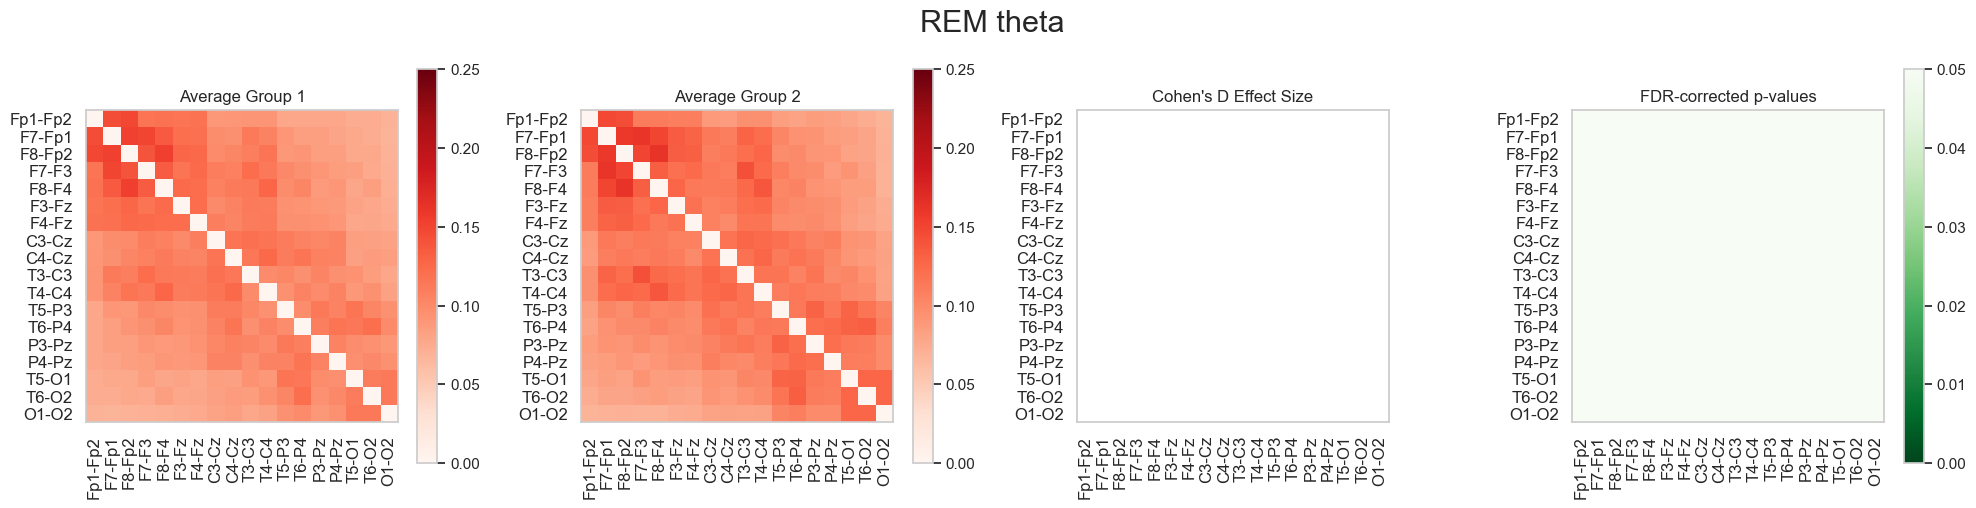

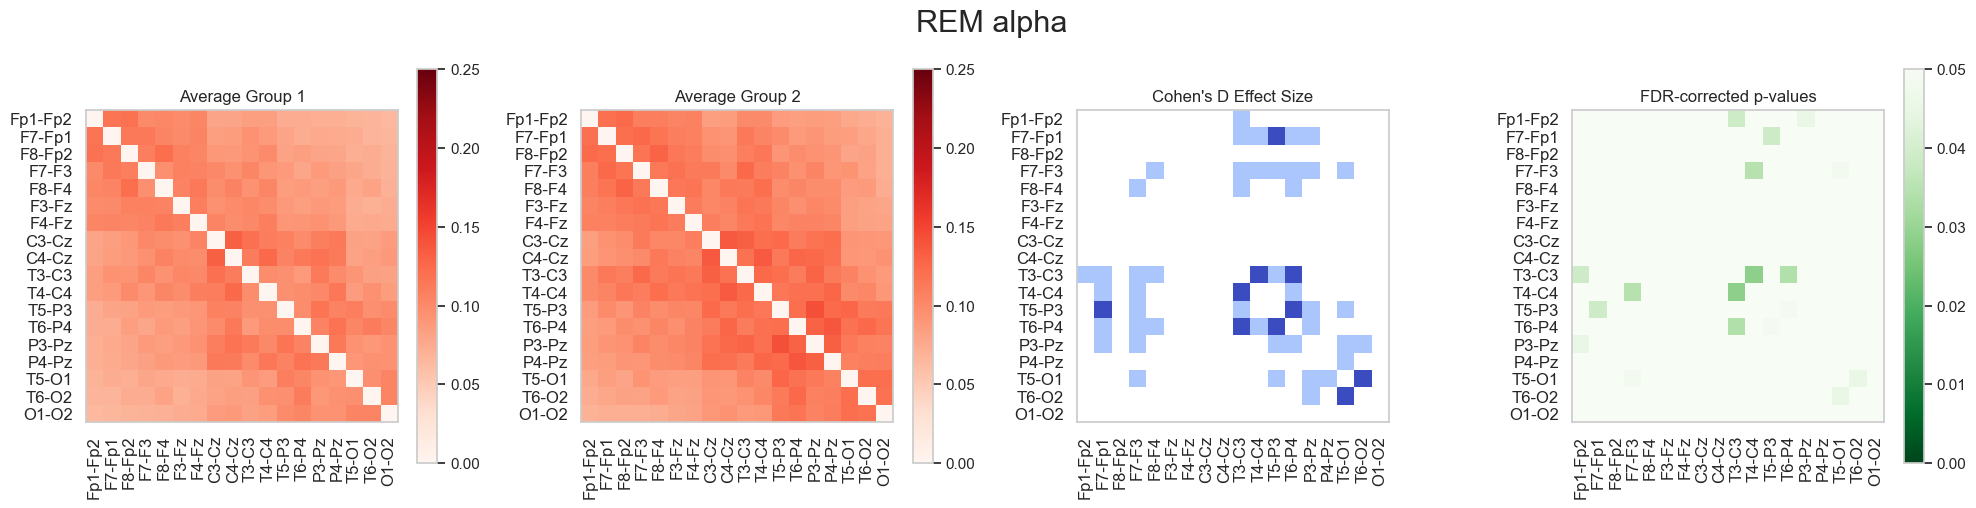

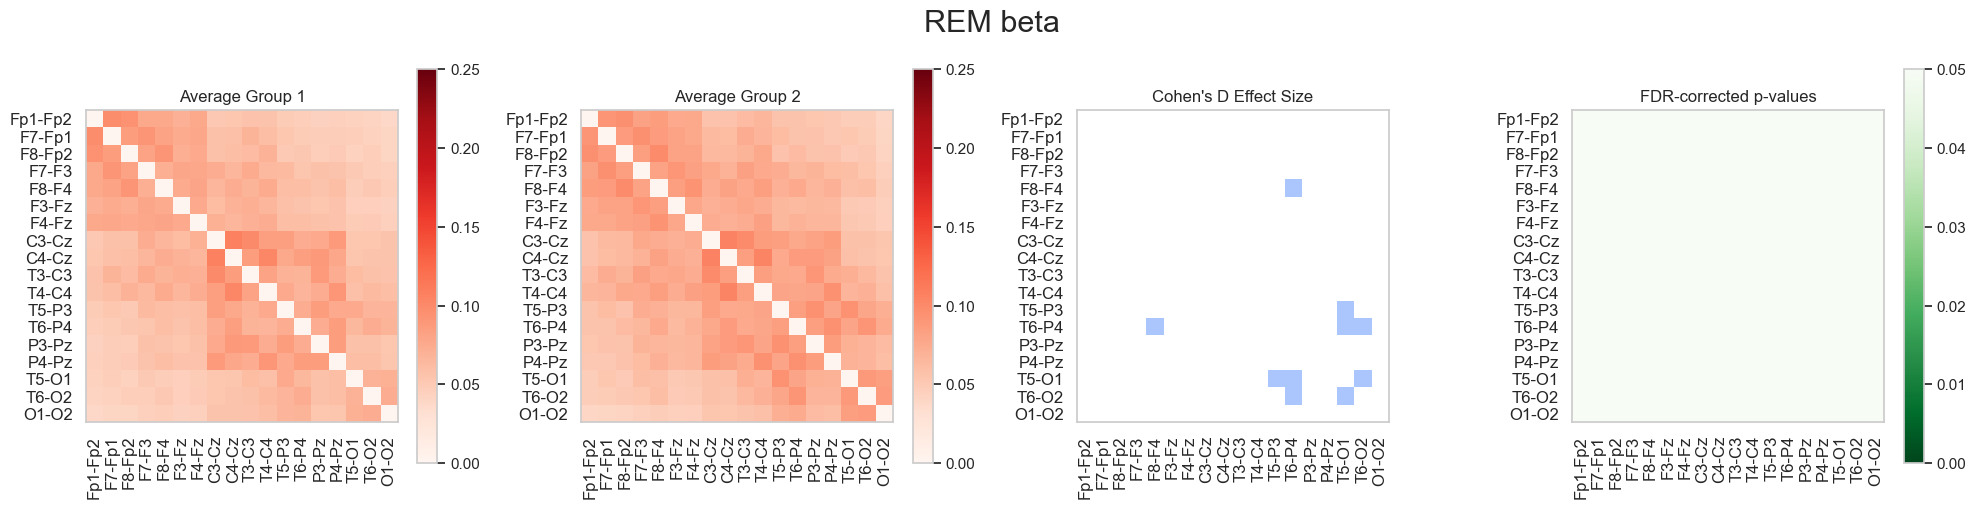

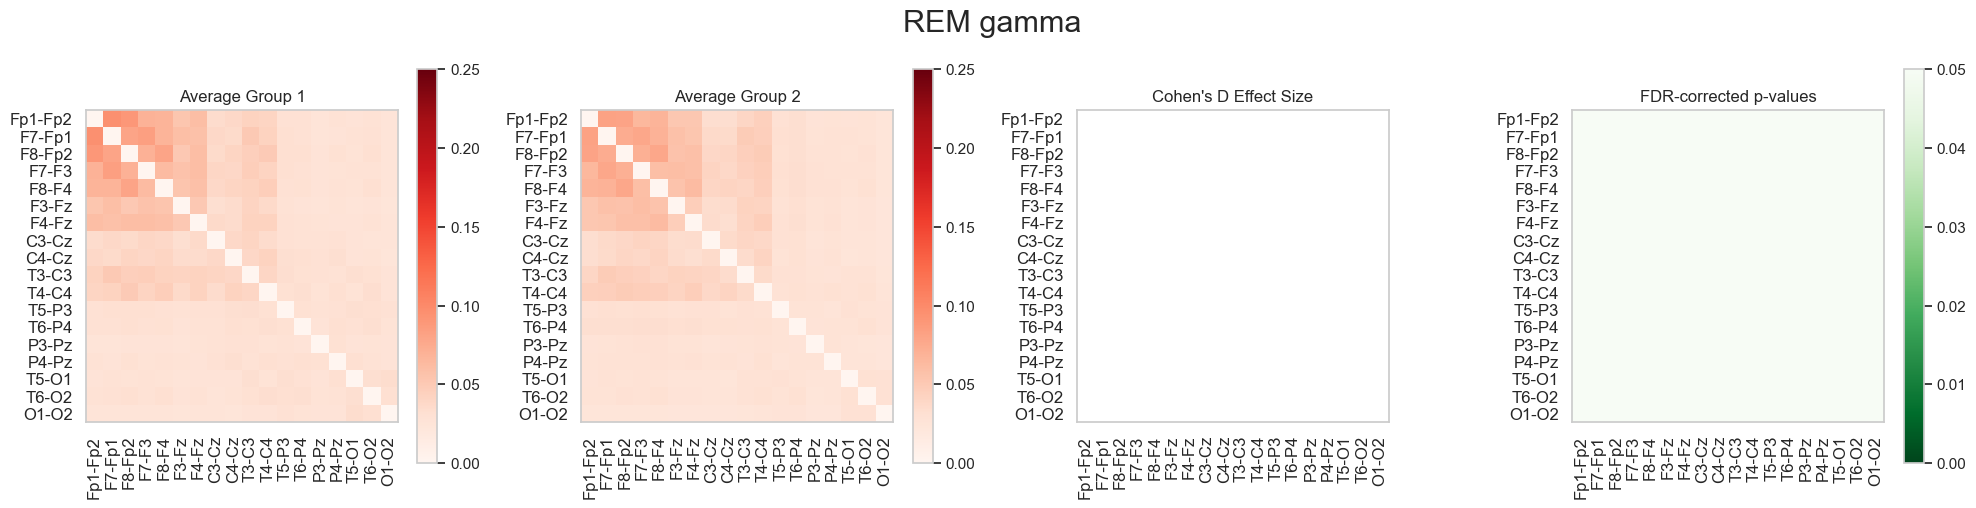

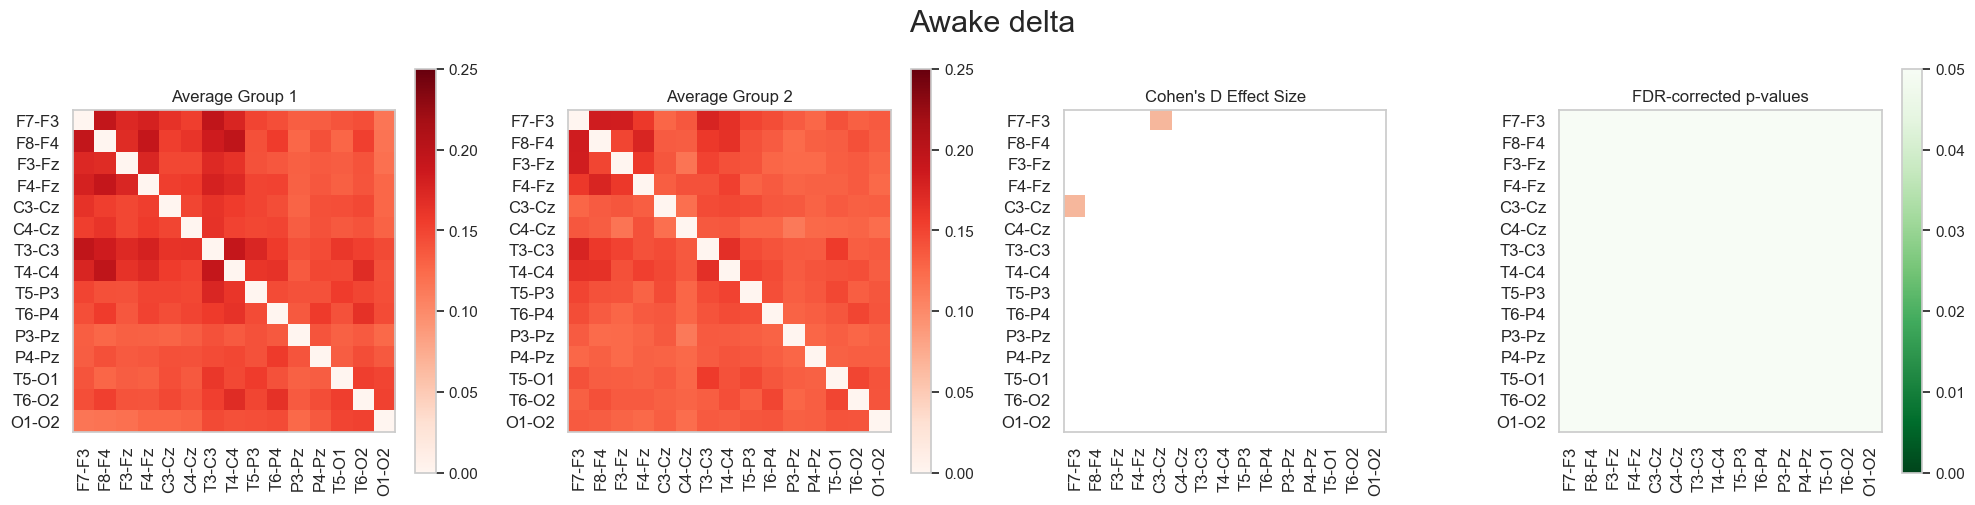

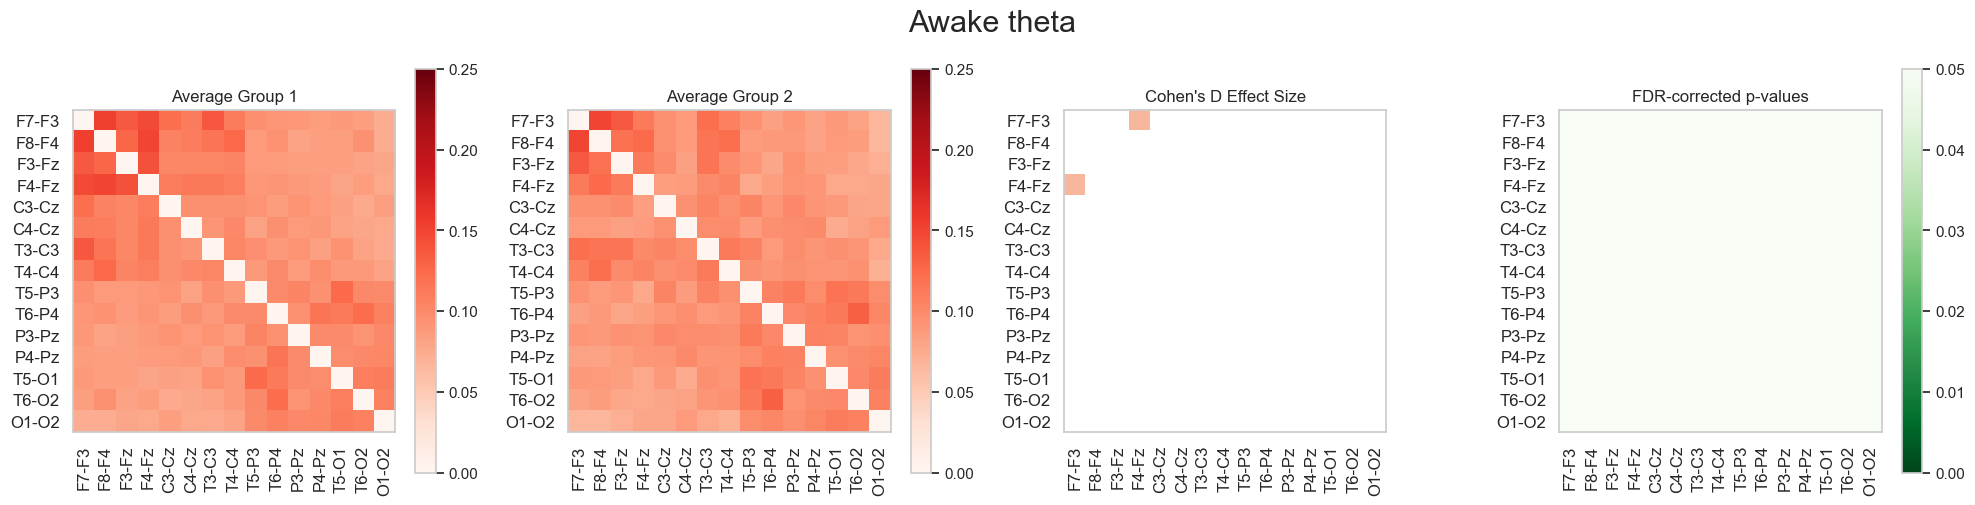

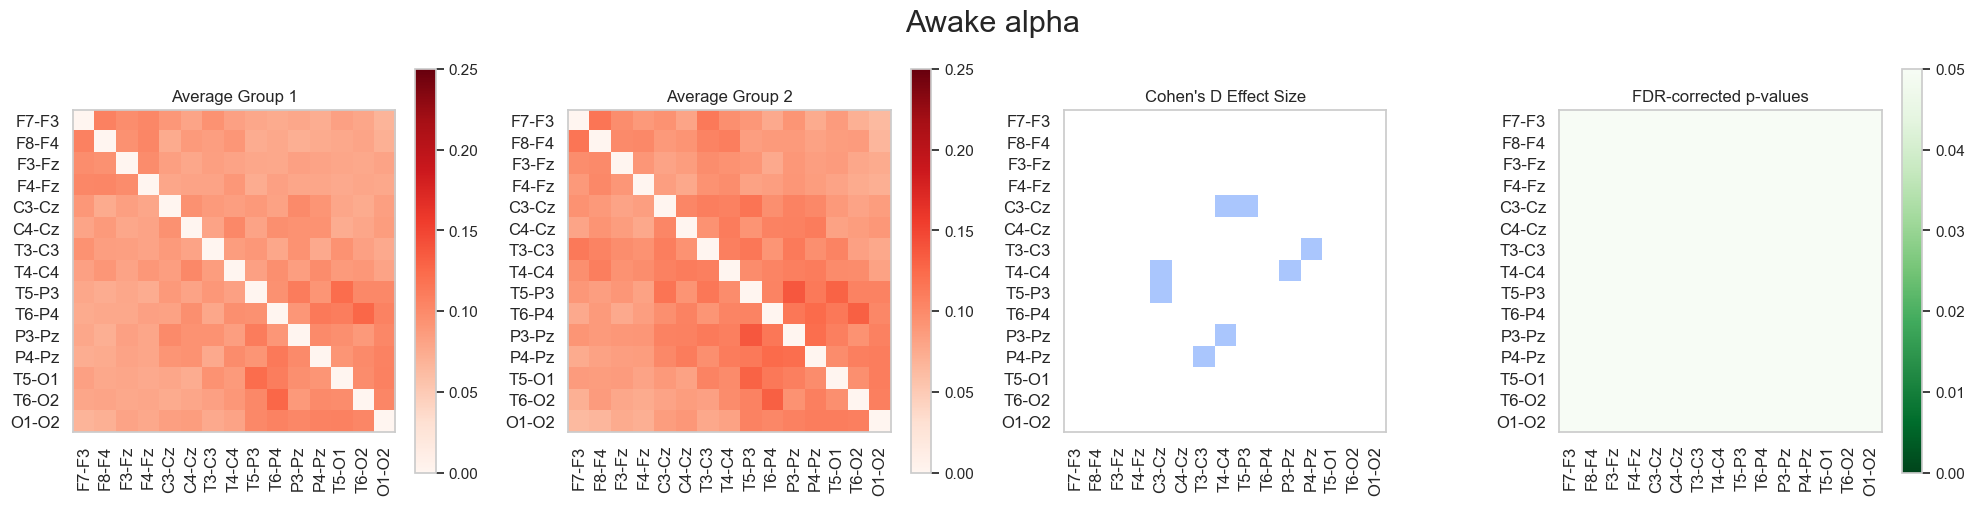

In [8]:
# Compare AD-NoEp vs HC with the AD-NoEp > HC contrast

# Plot Cohen's d matrices with significant p-values after FDR correction as asterisks
# The formula for the number of p-values to correct, for example, in upper triangular matrices without diagonals would be "n*(n-1)/2 * stages * freq bands", with n as the number of channels
# If we exclude channels from the awake from awake analysis comprising Fp1 and Fp2 (i.e., Fp1-Fp2, F7-Fp1, F8-Fp2),
# corresponding to [0,1,2] rows in the connectivity matrices
# And we exlude the beta and gamma bands from the awake state, the calculation is the following:
# (18*17)/2 * 2 * 5 + (15*14/2) * 1 * 3 = 1530 + 315 = 1845

# Now adding inputs for Cohen's d thresholds
# The matrix entries between -th1 and +th1 will be displayed white

cohens_d_channels_w_pval(adnoep_aec, hc_aec, channels, threshold_1=0.6, threshold_2=0.8, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

Number of channel-wise p-values to correct = 1845



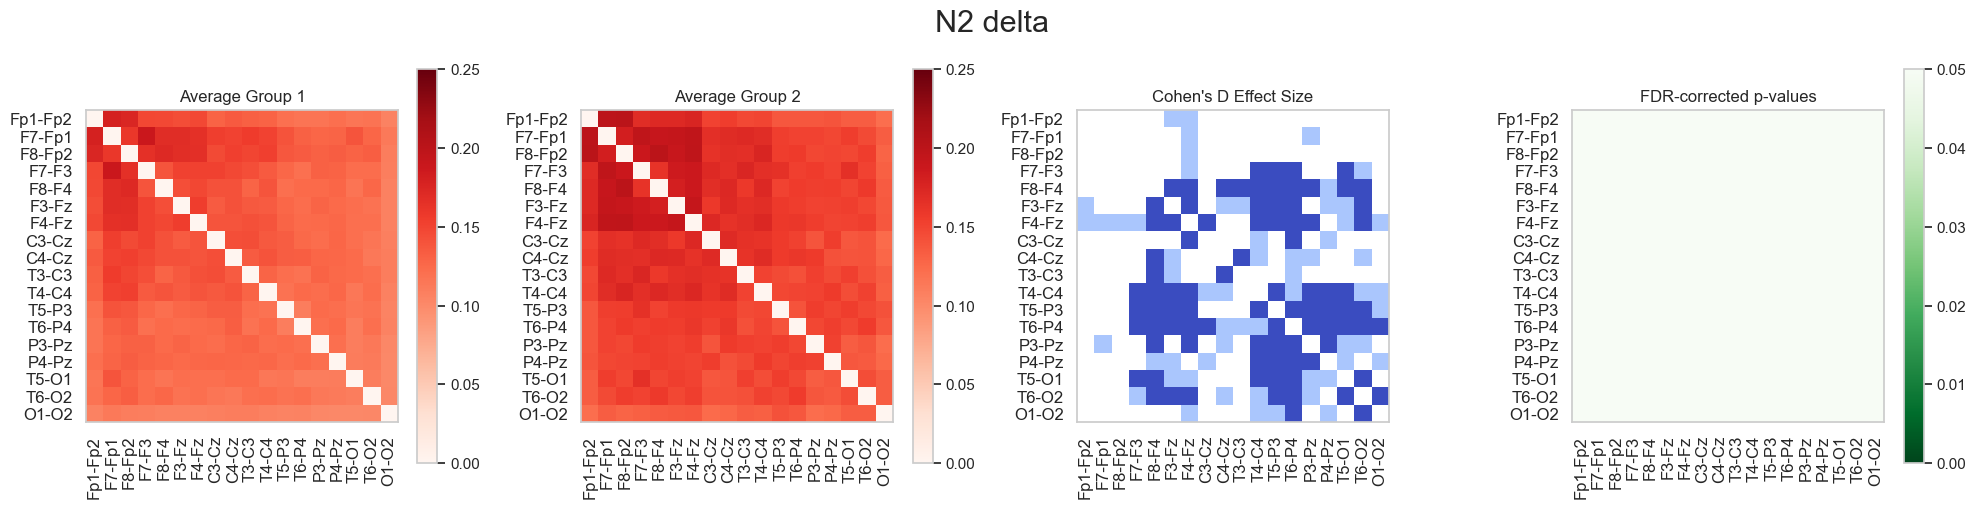

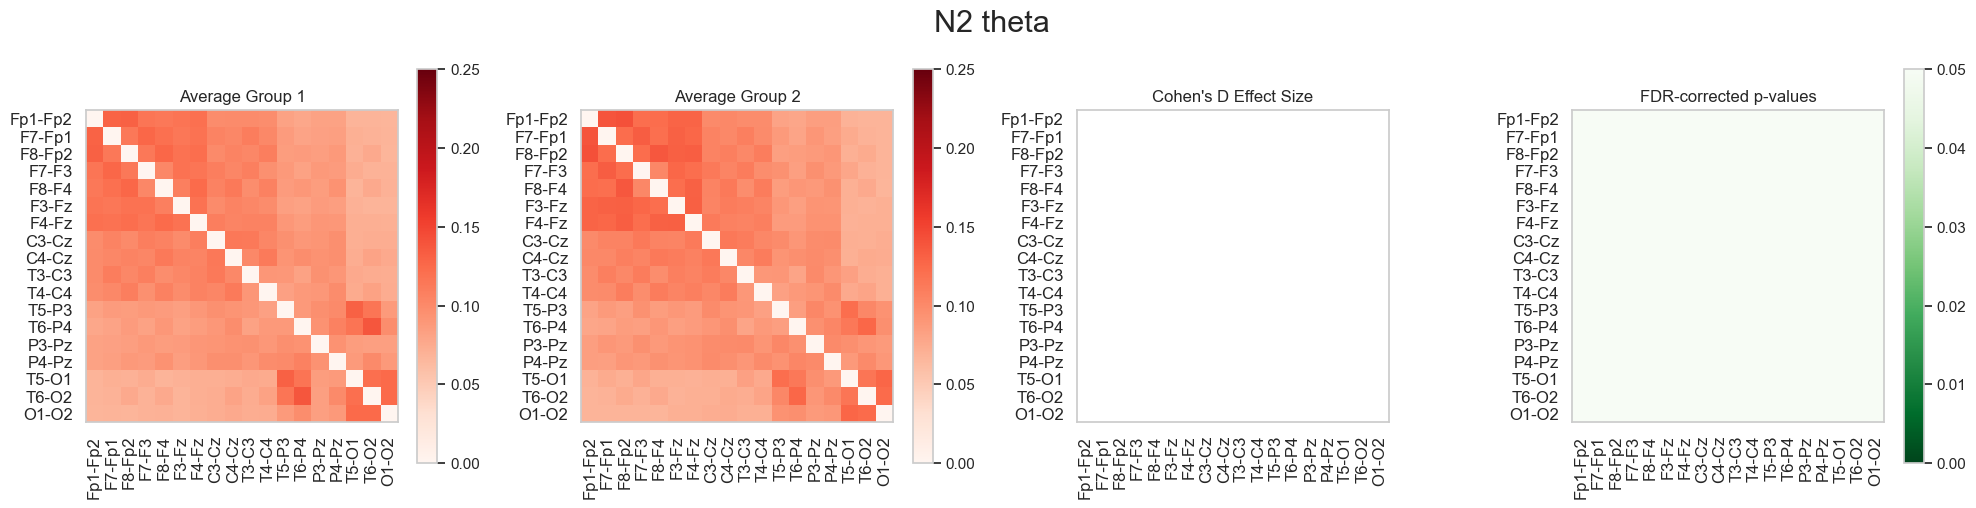

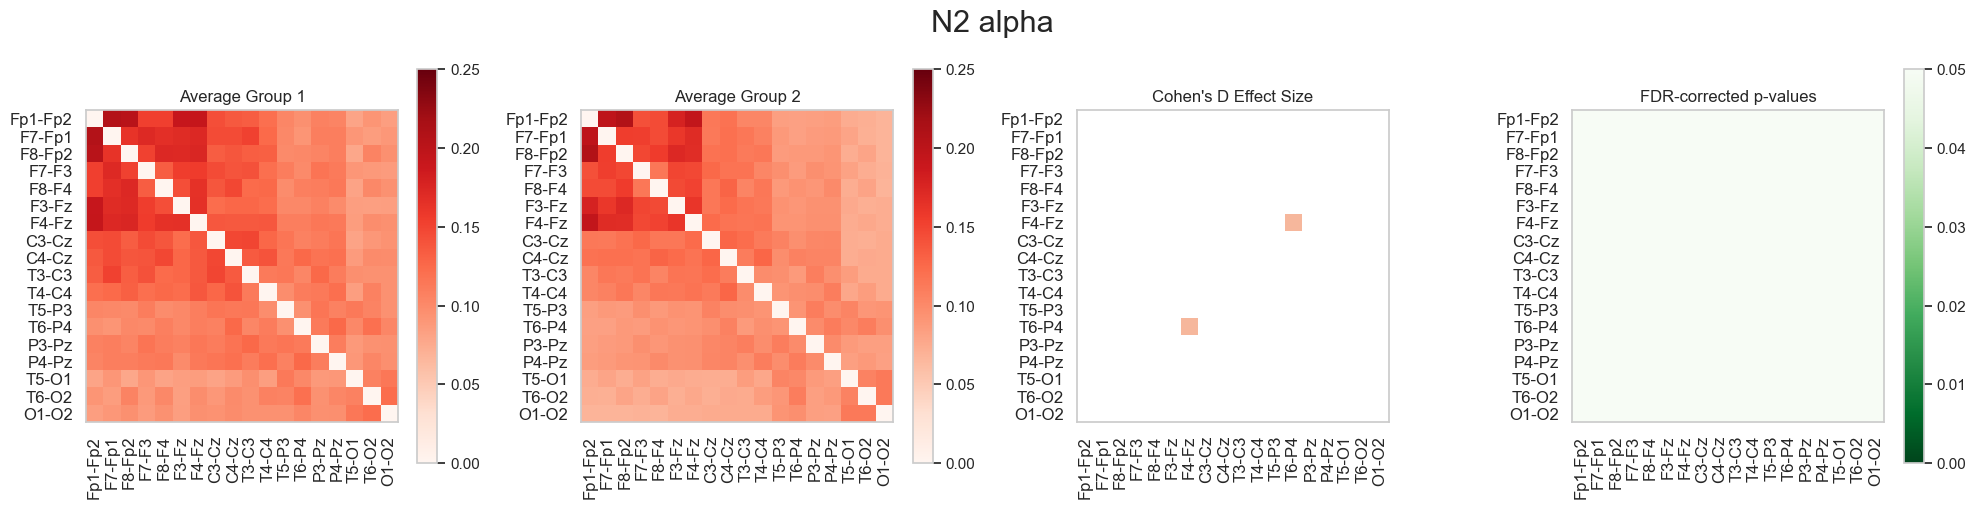

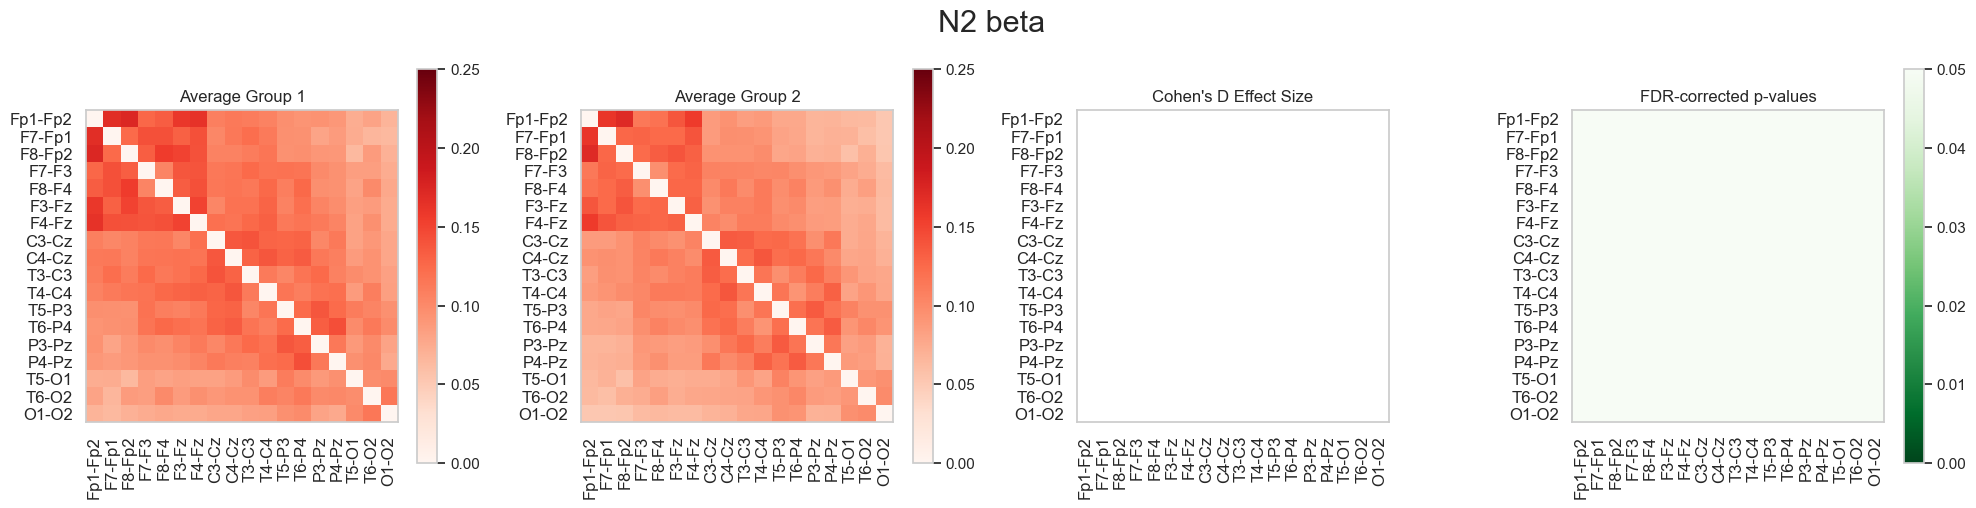

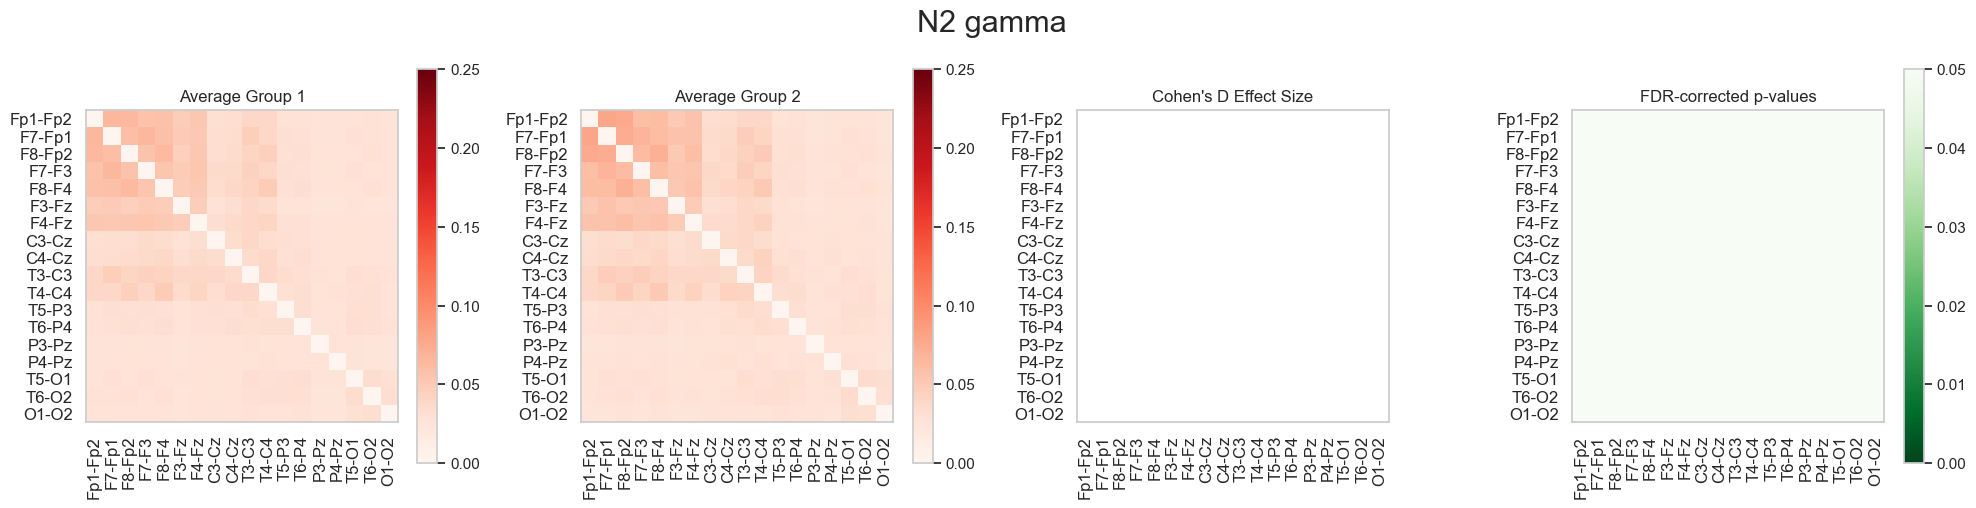

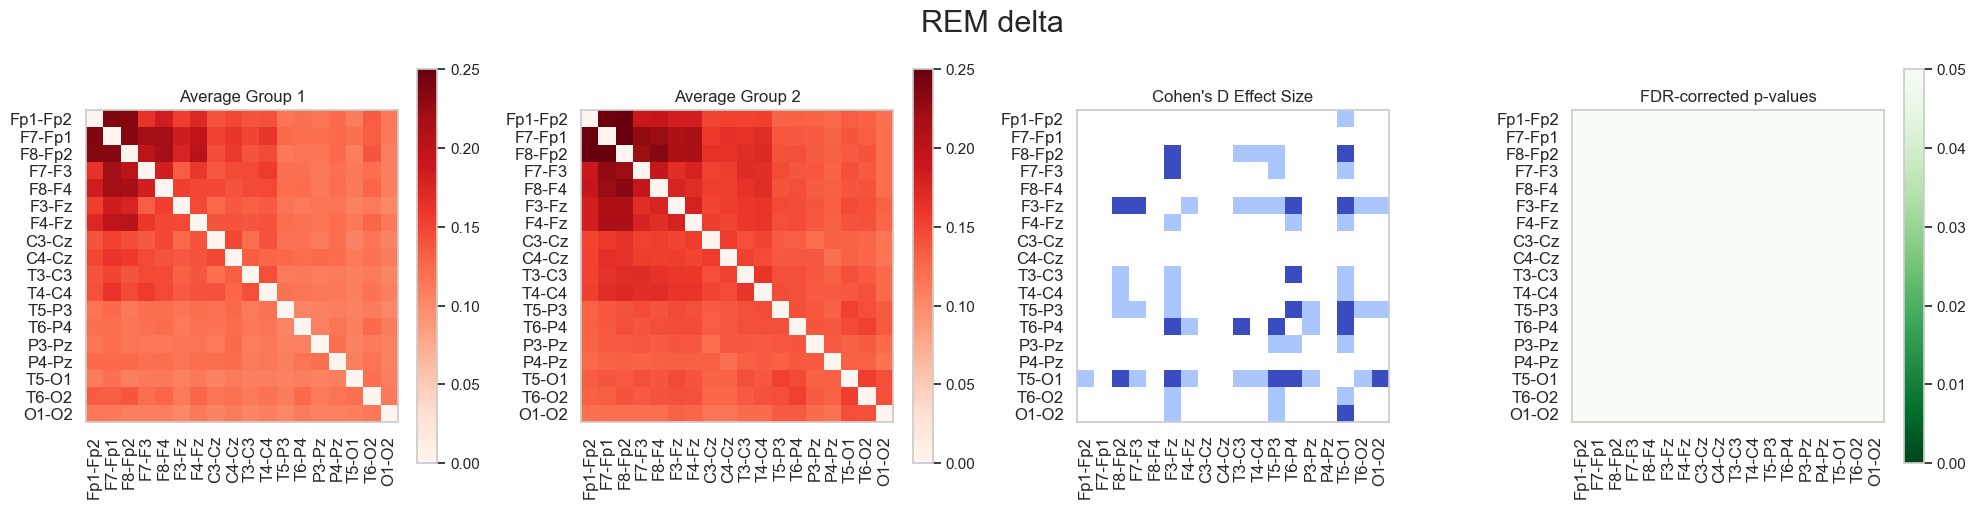

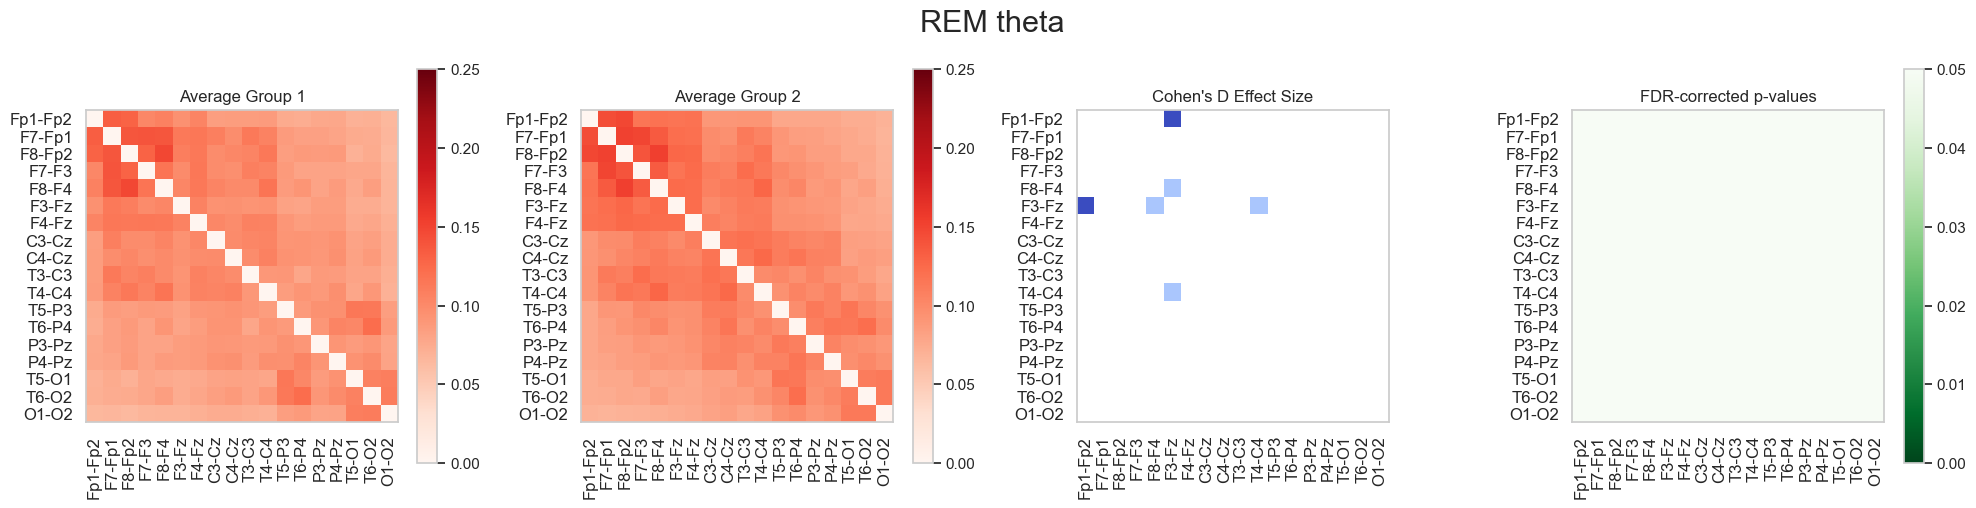

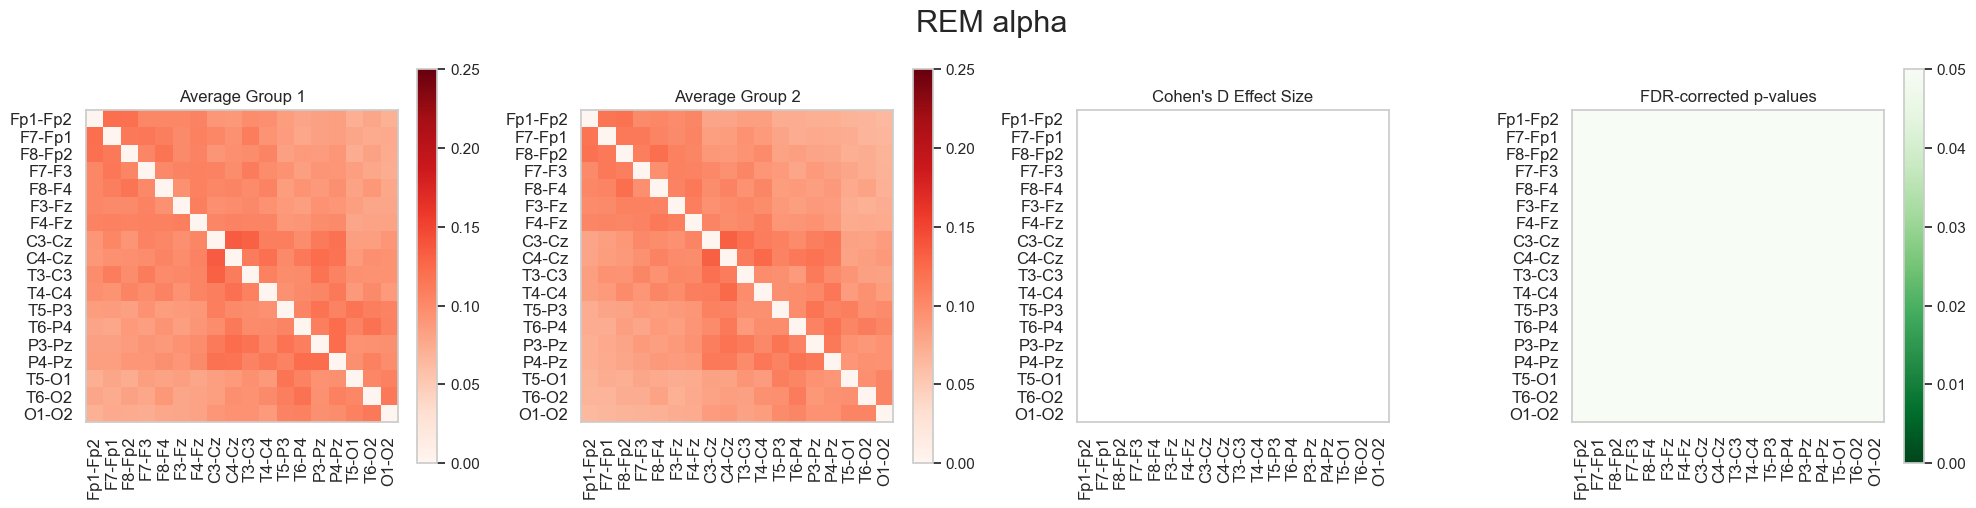

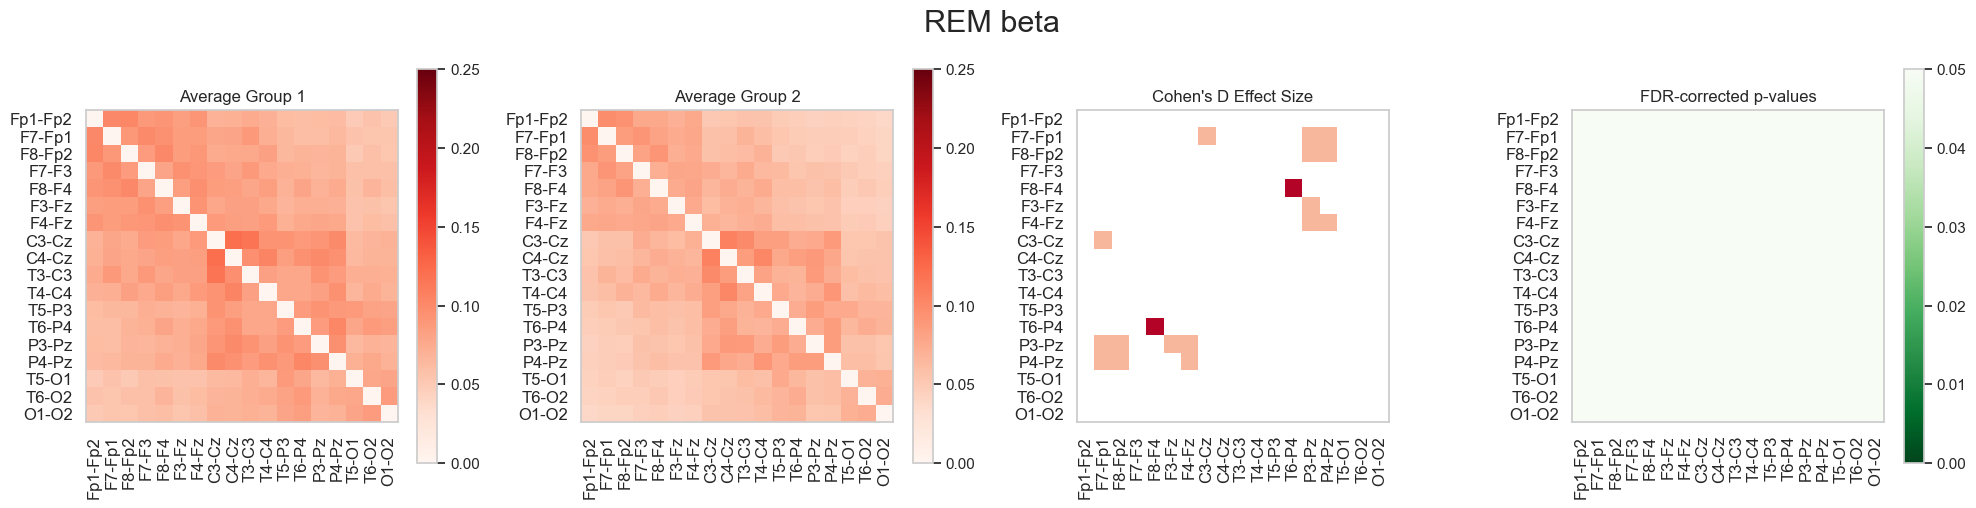

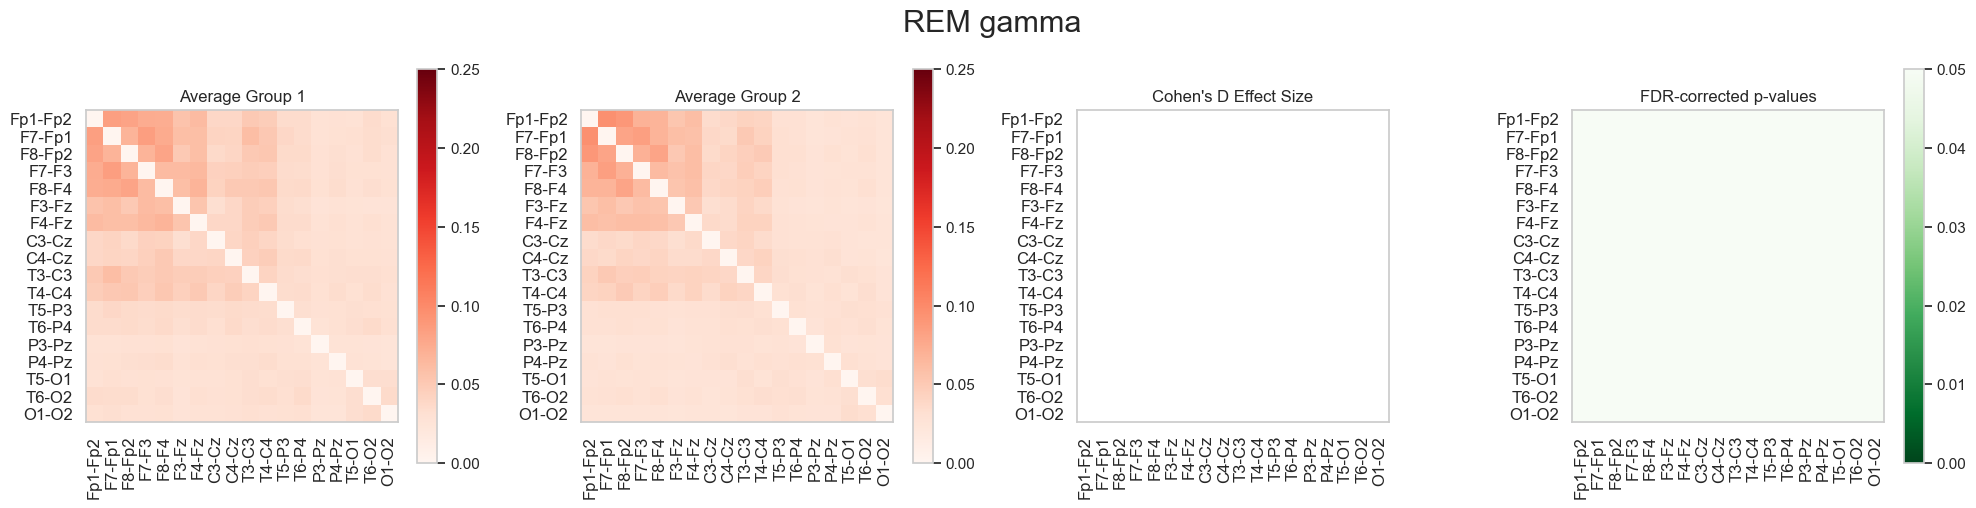

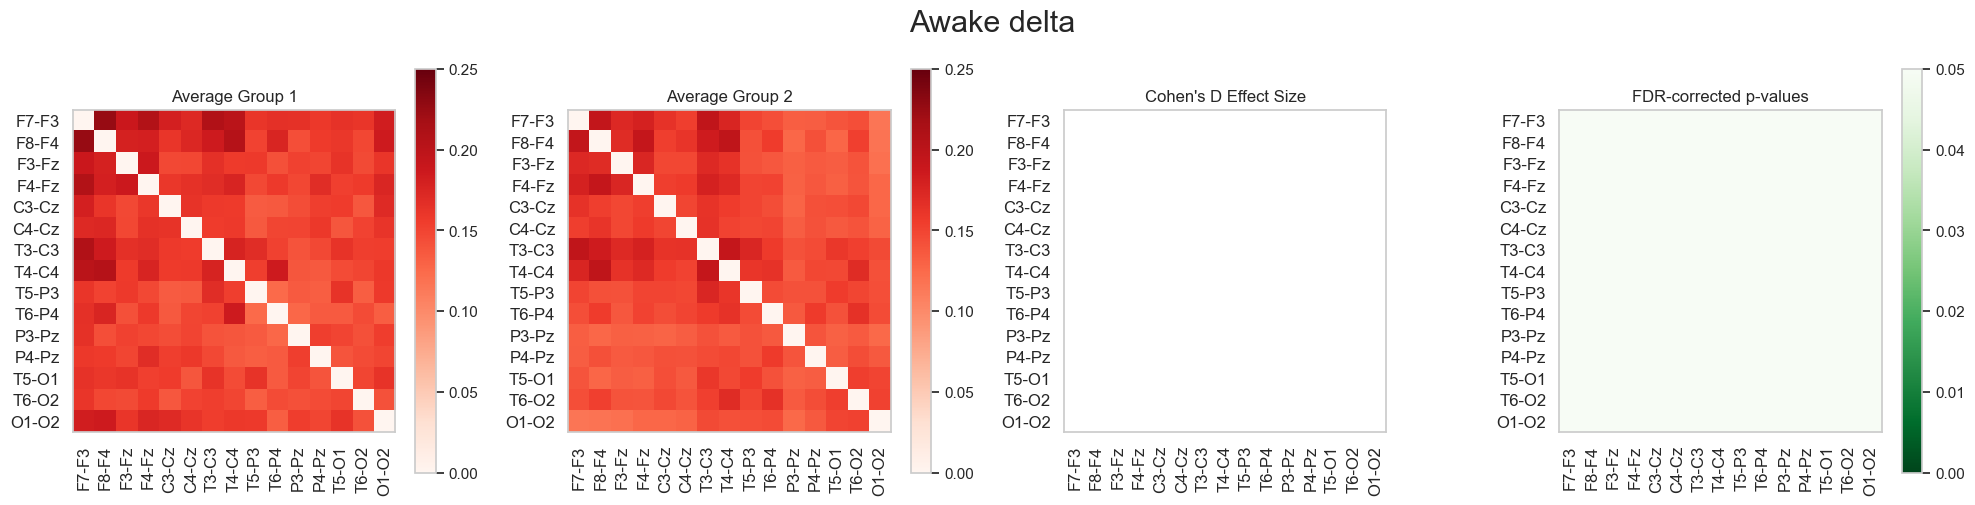

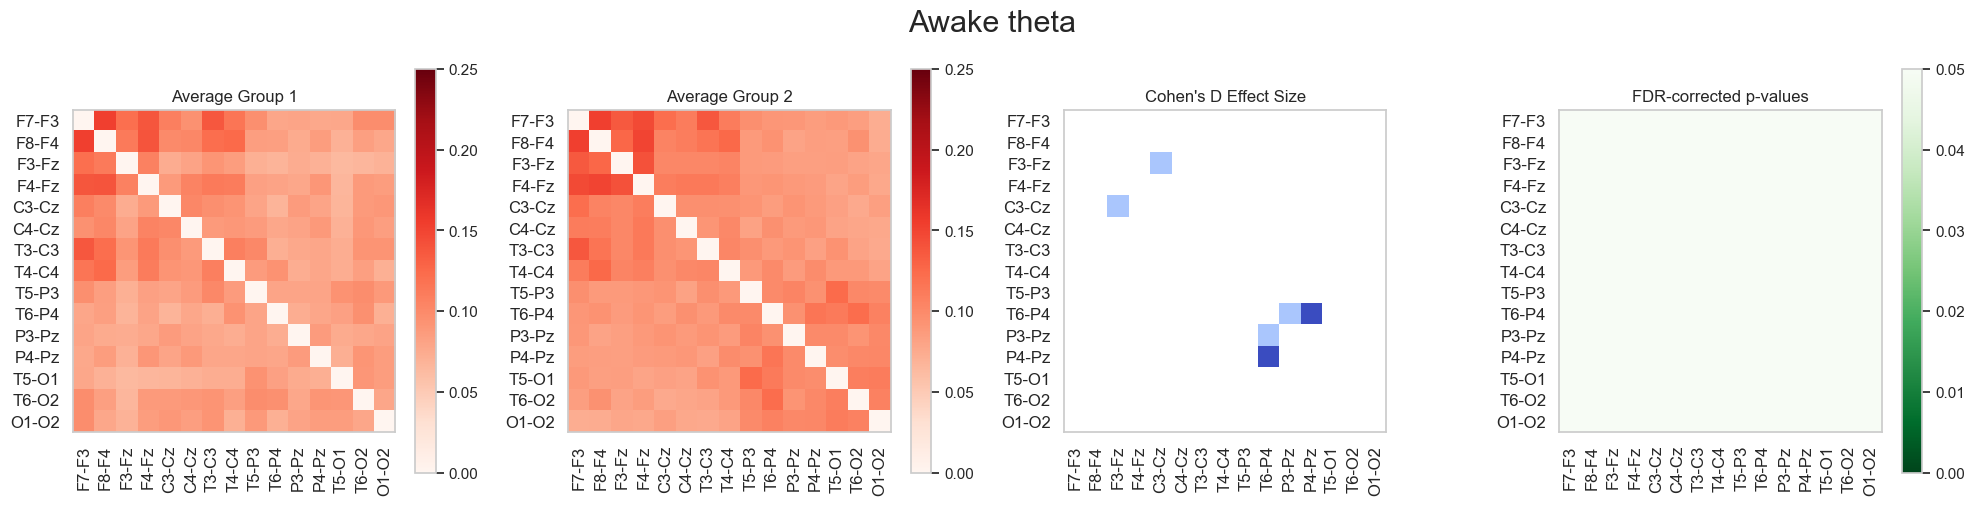

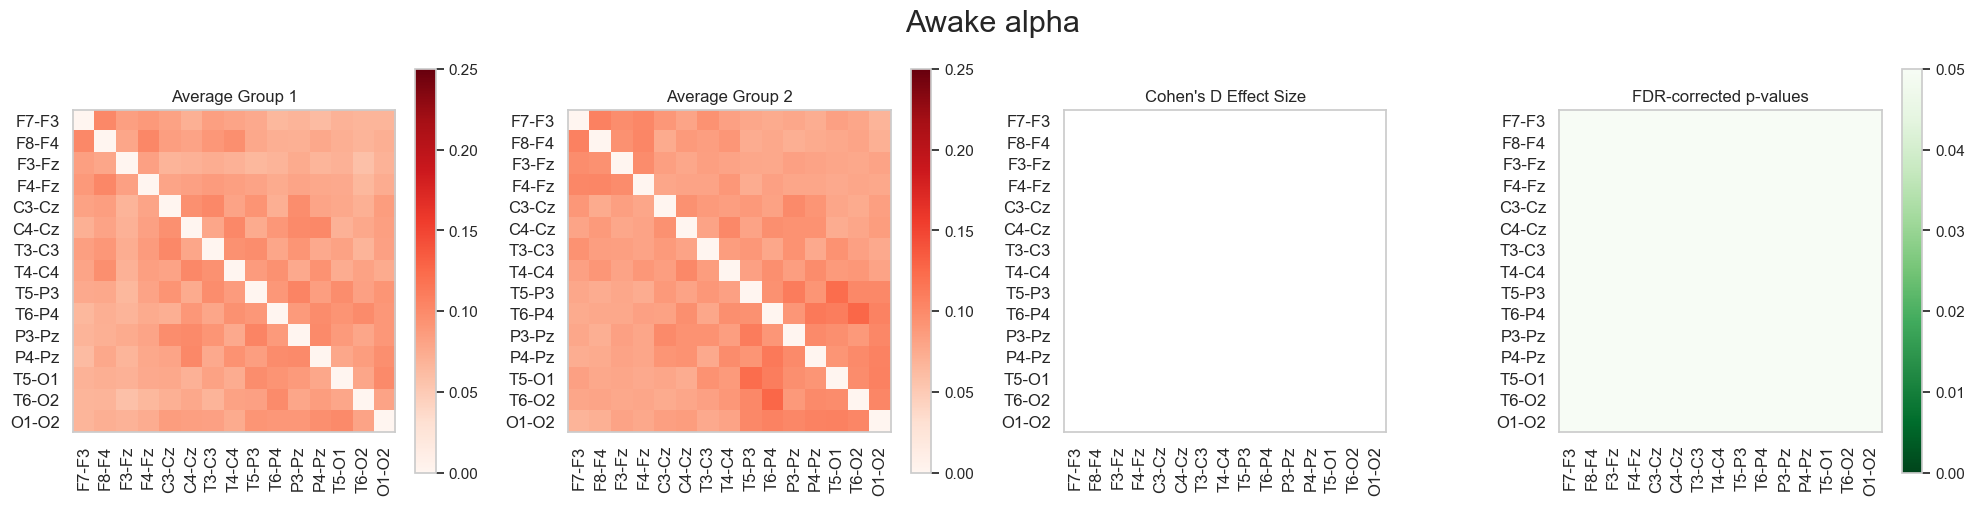

In [9]:
# Compare AD-Ep vs AD-NoEp with the AD-Ep > AD-NoEp contrast
cohens_d_channels_w_pval(adep_aec, adnoep_aec, channels, threshold_1=0.7, threshold_2=0.8, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

Number of channel-wise p-values to correct = 1845



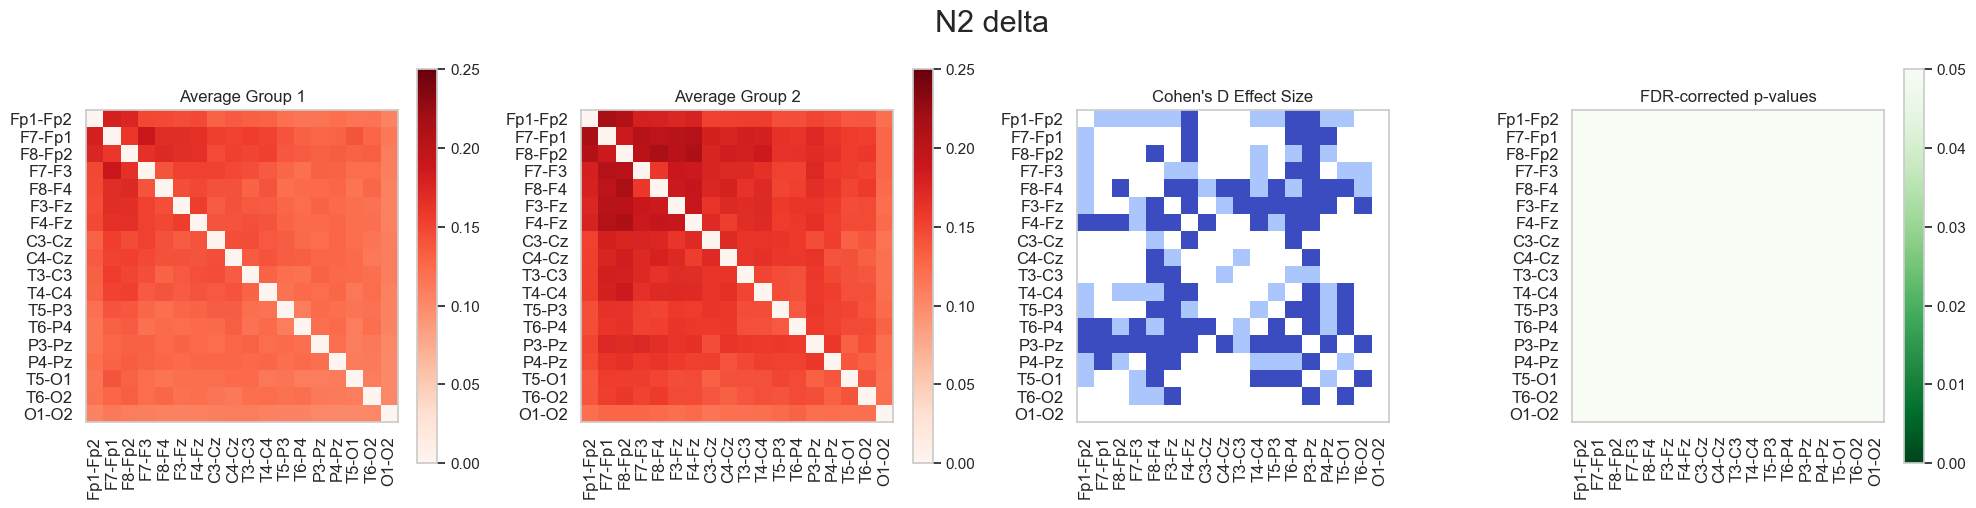

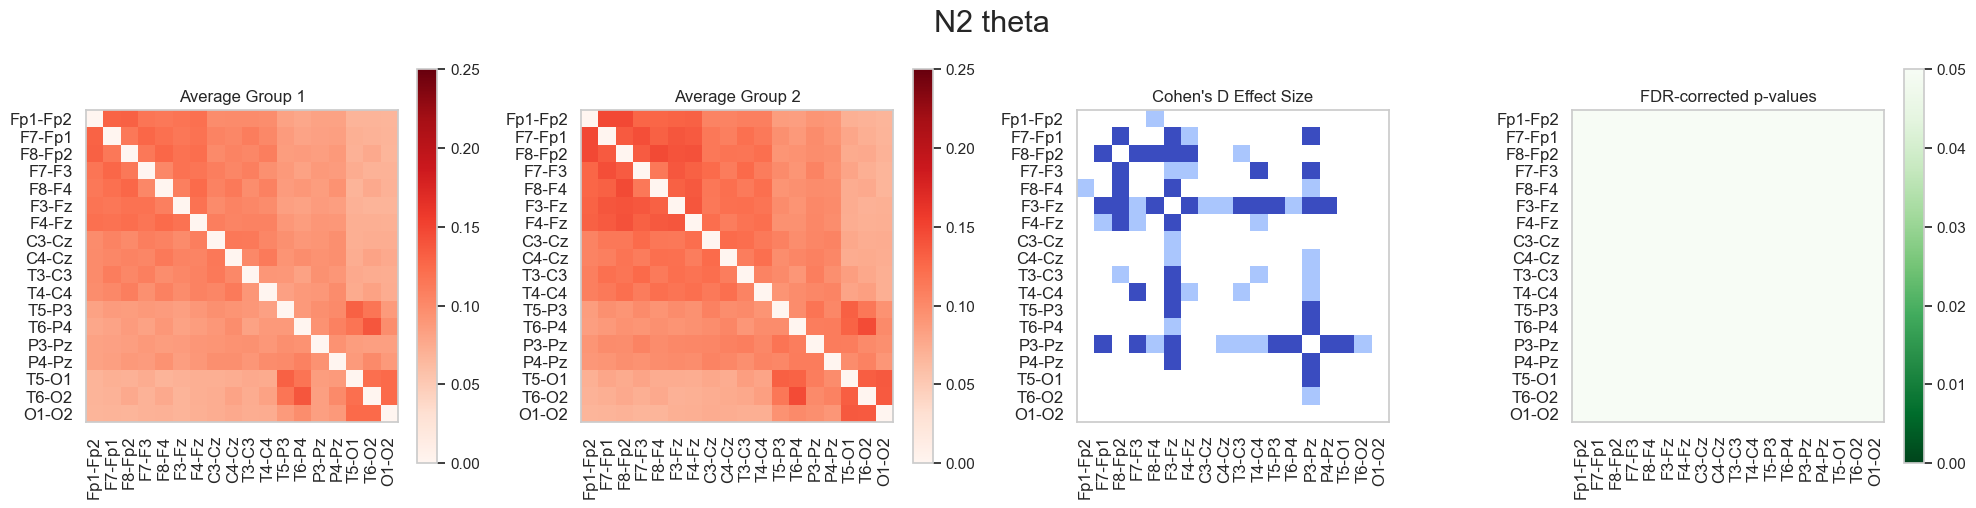

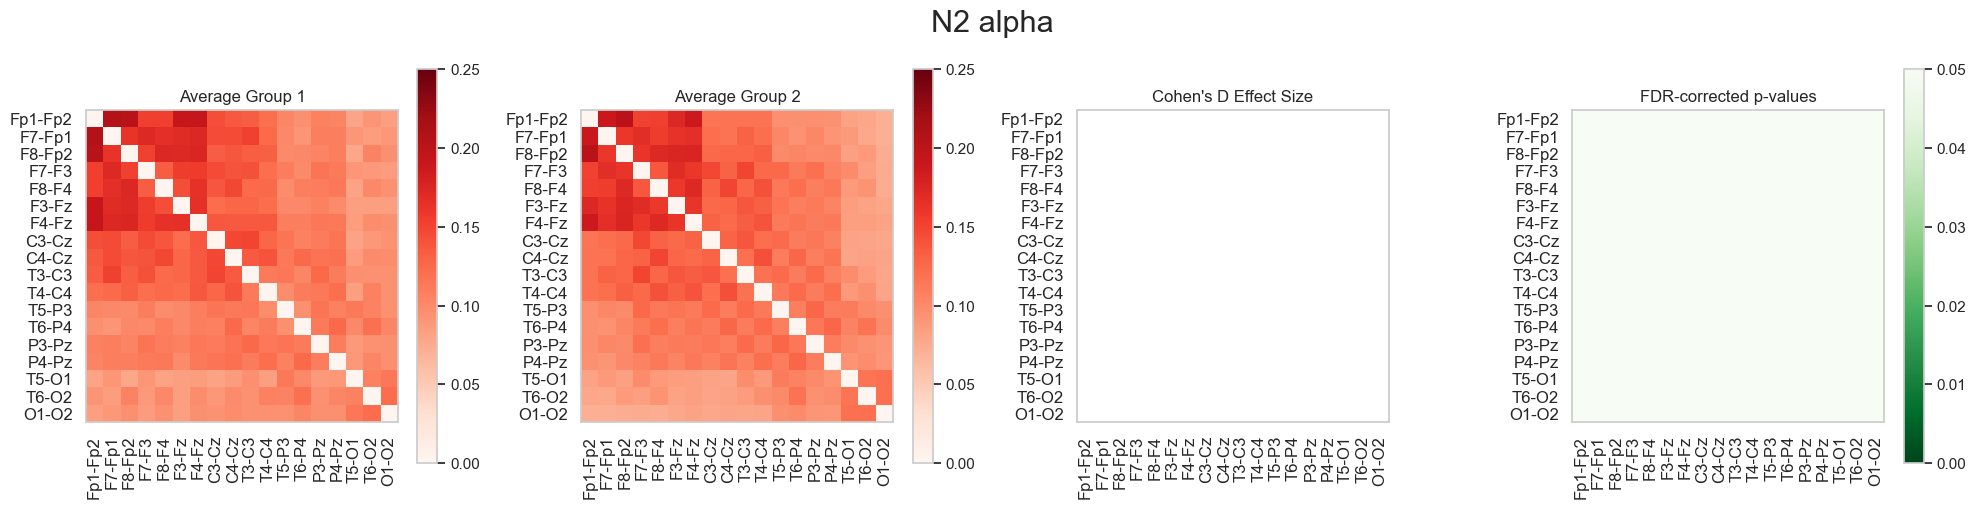

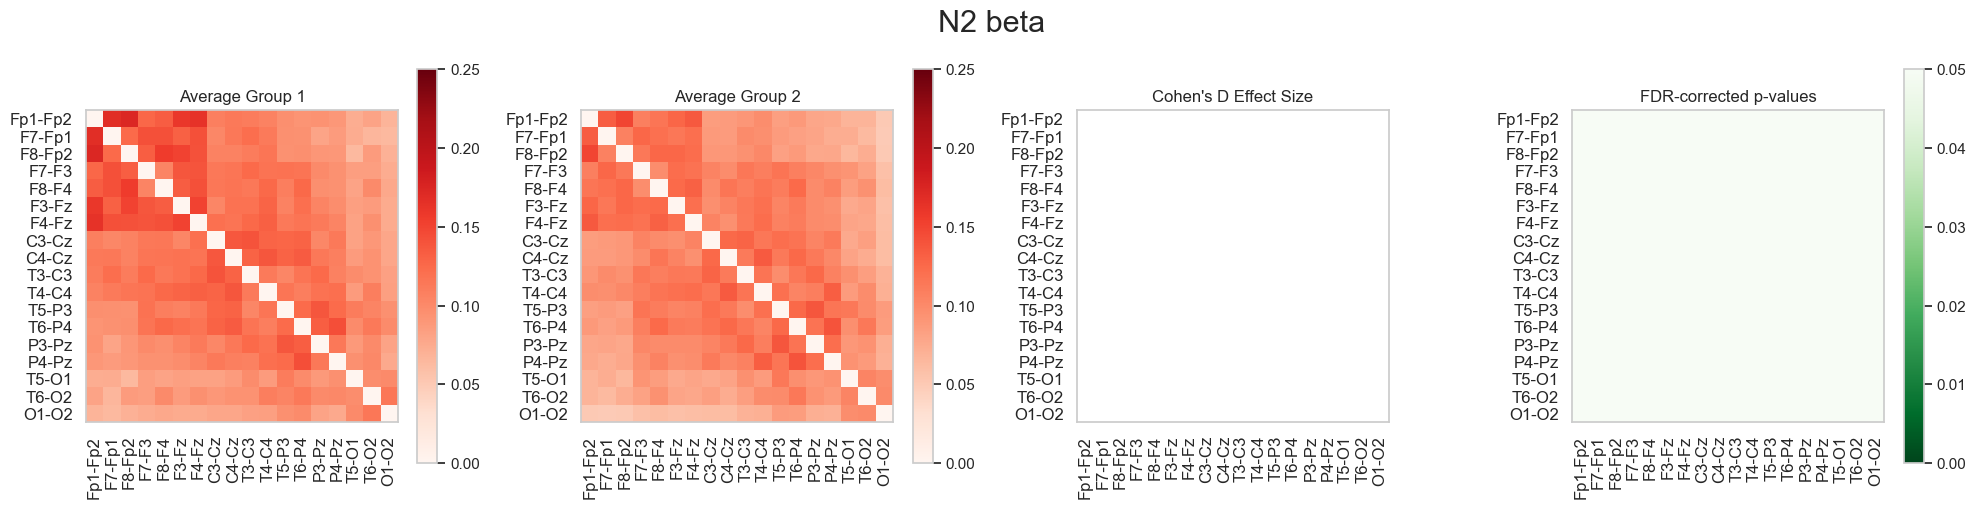

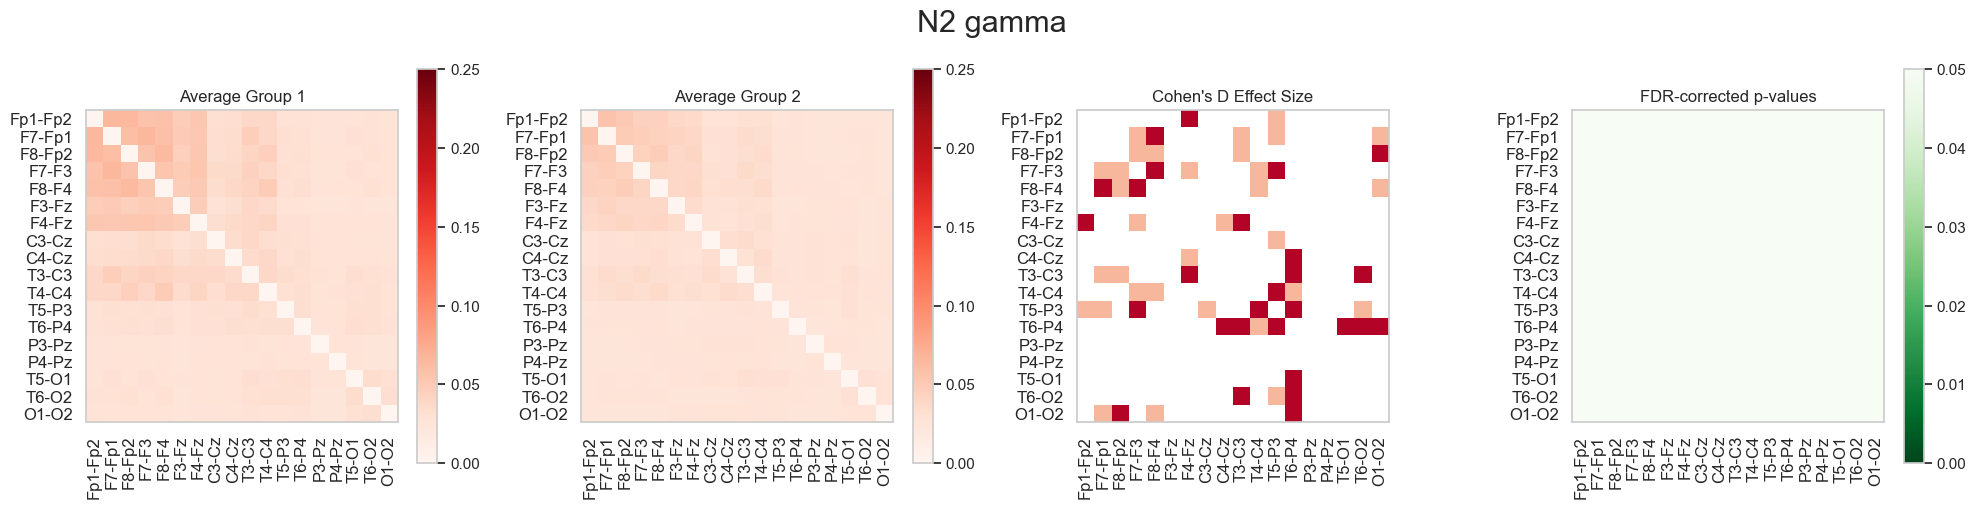

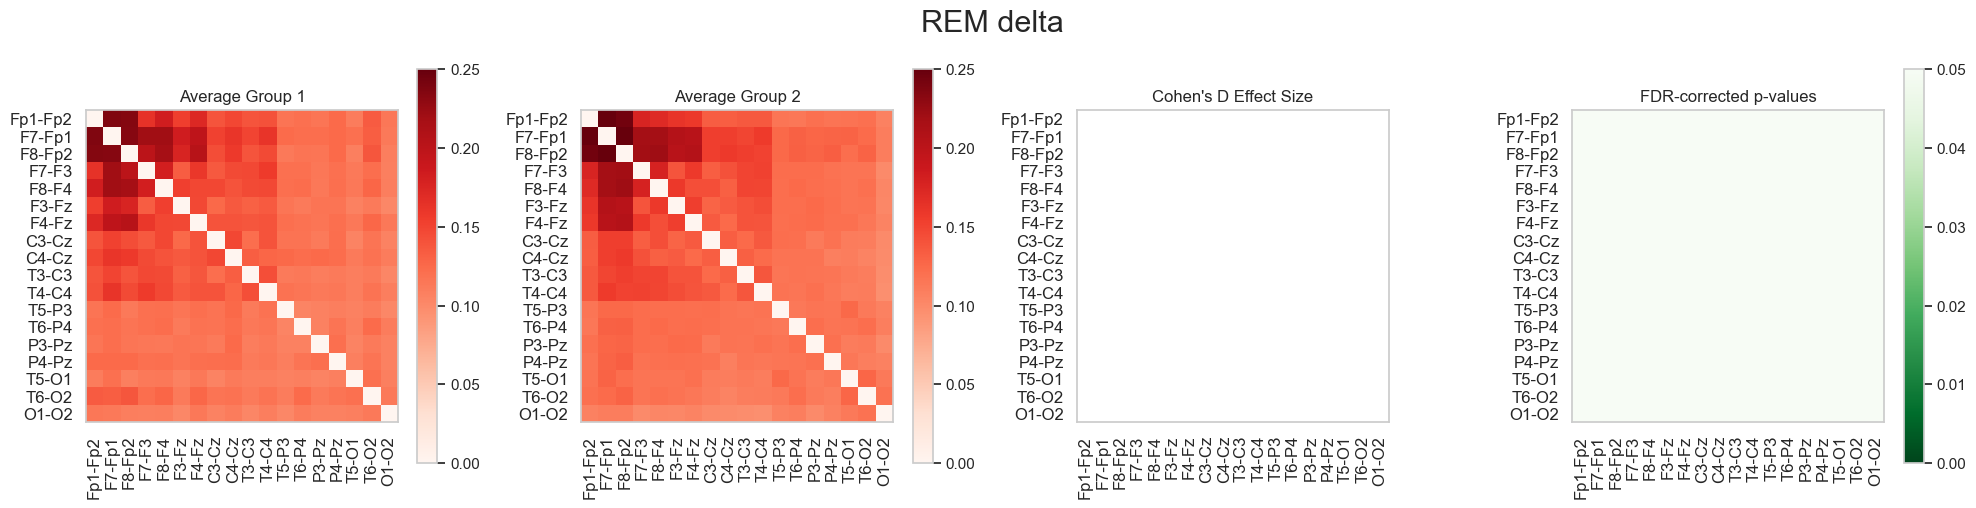

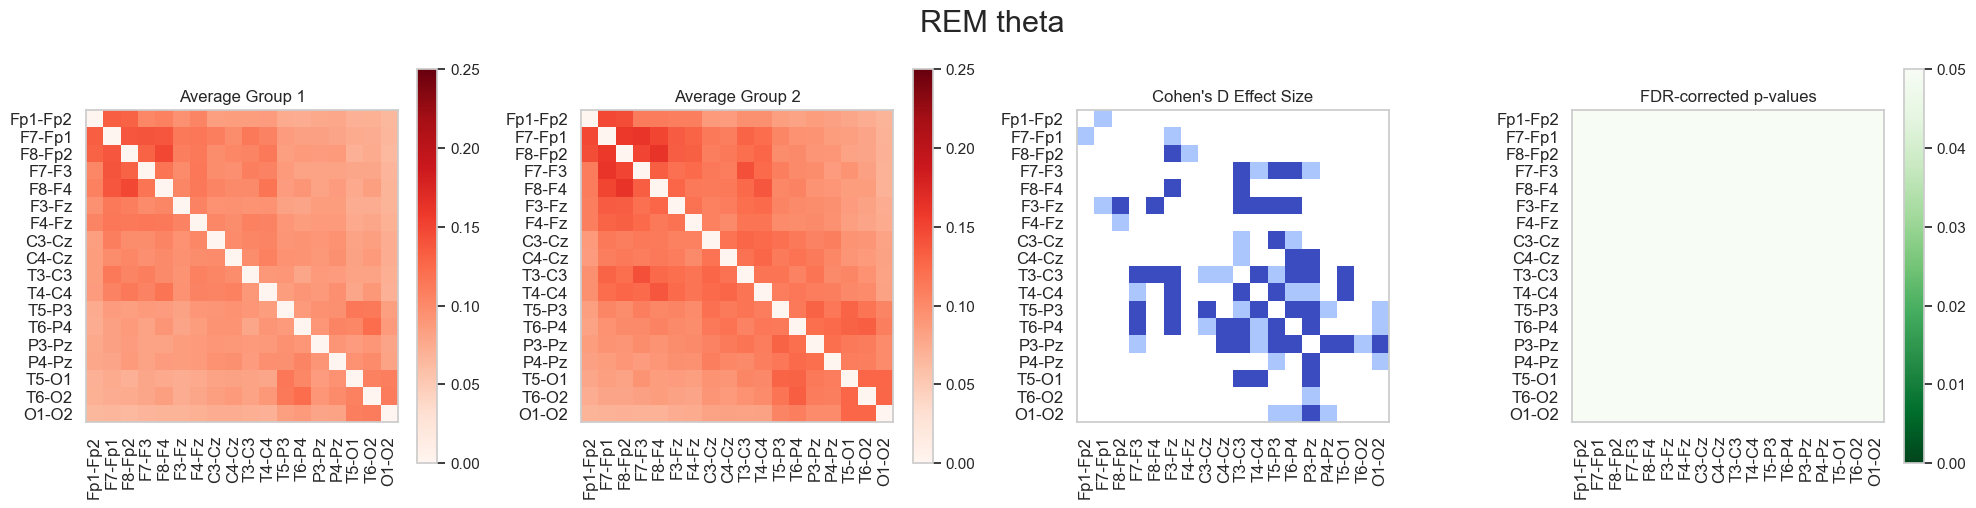

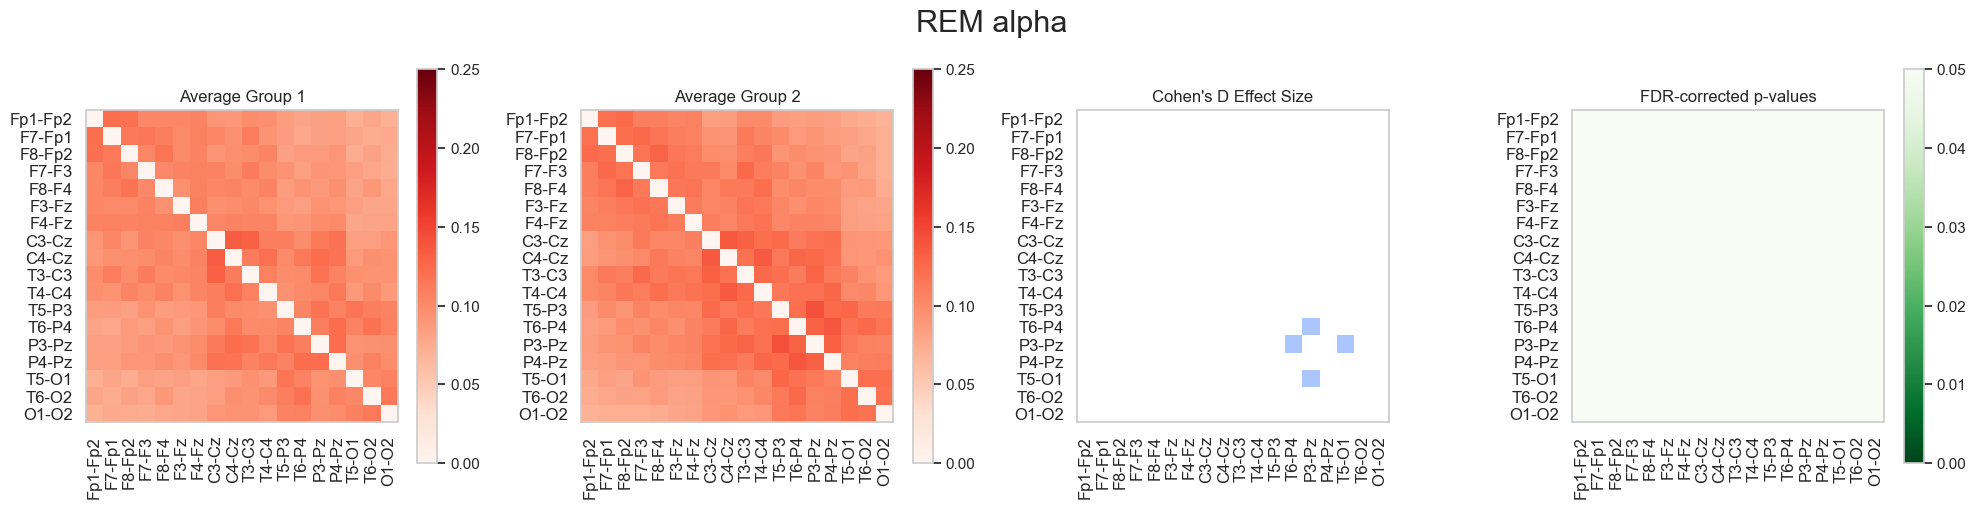

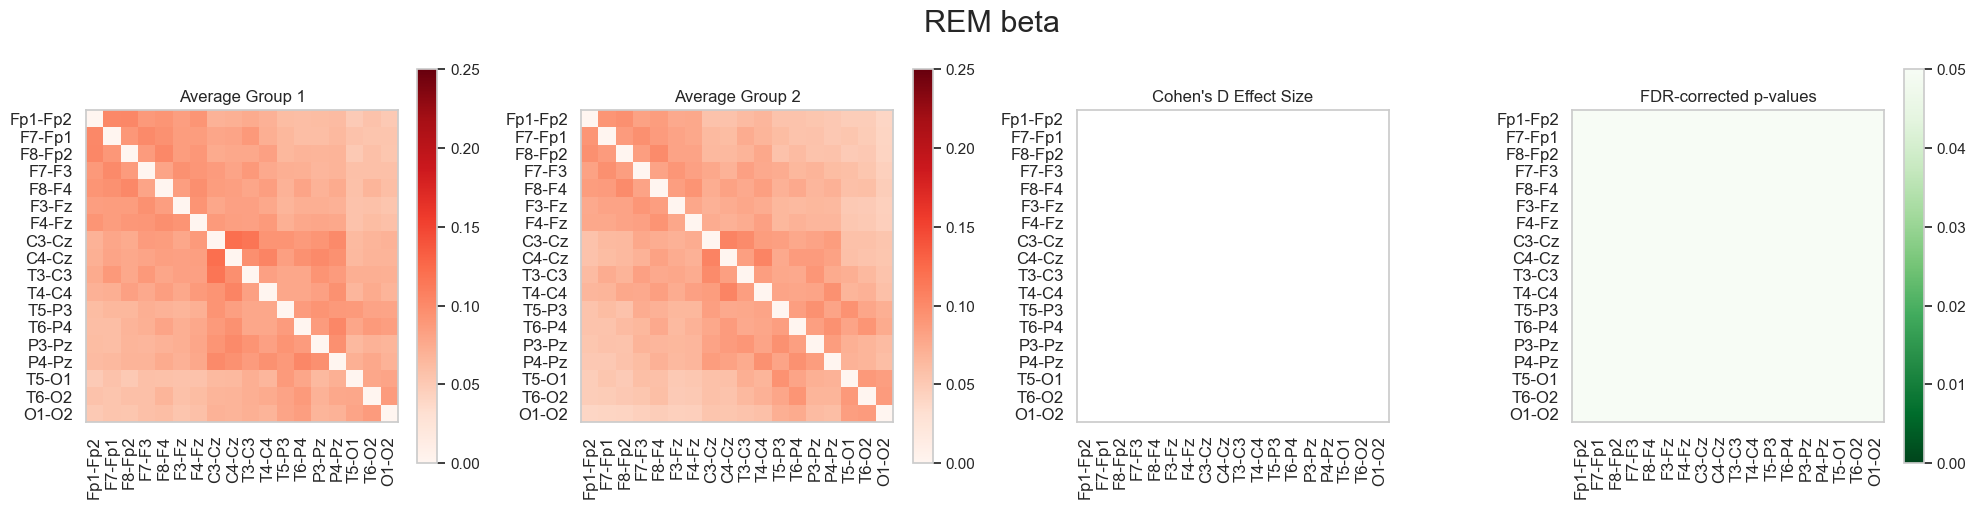

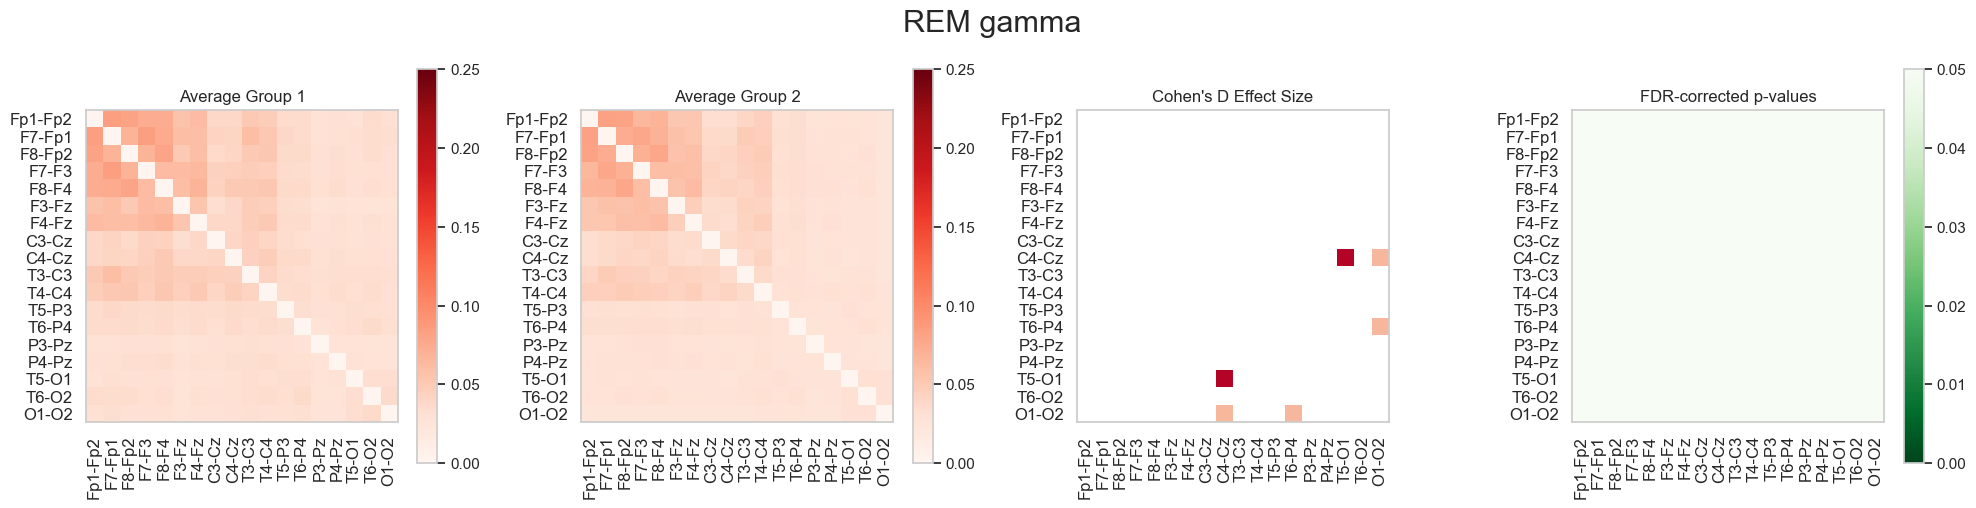

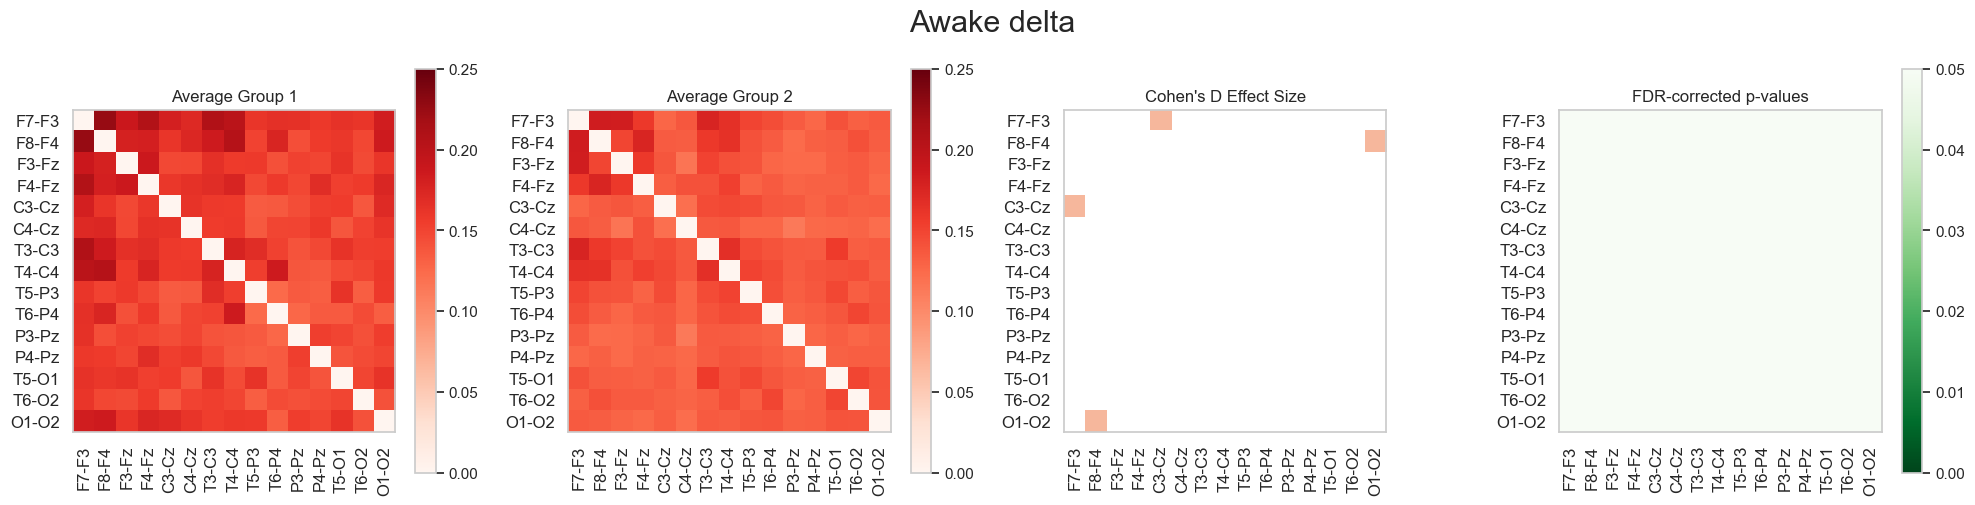

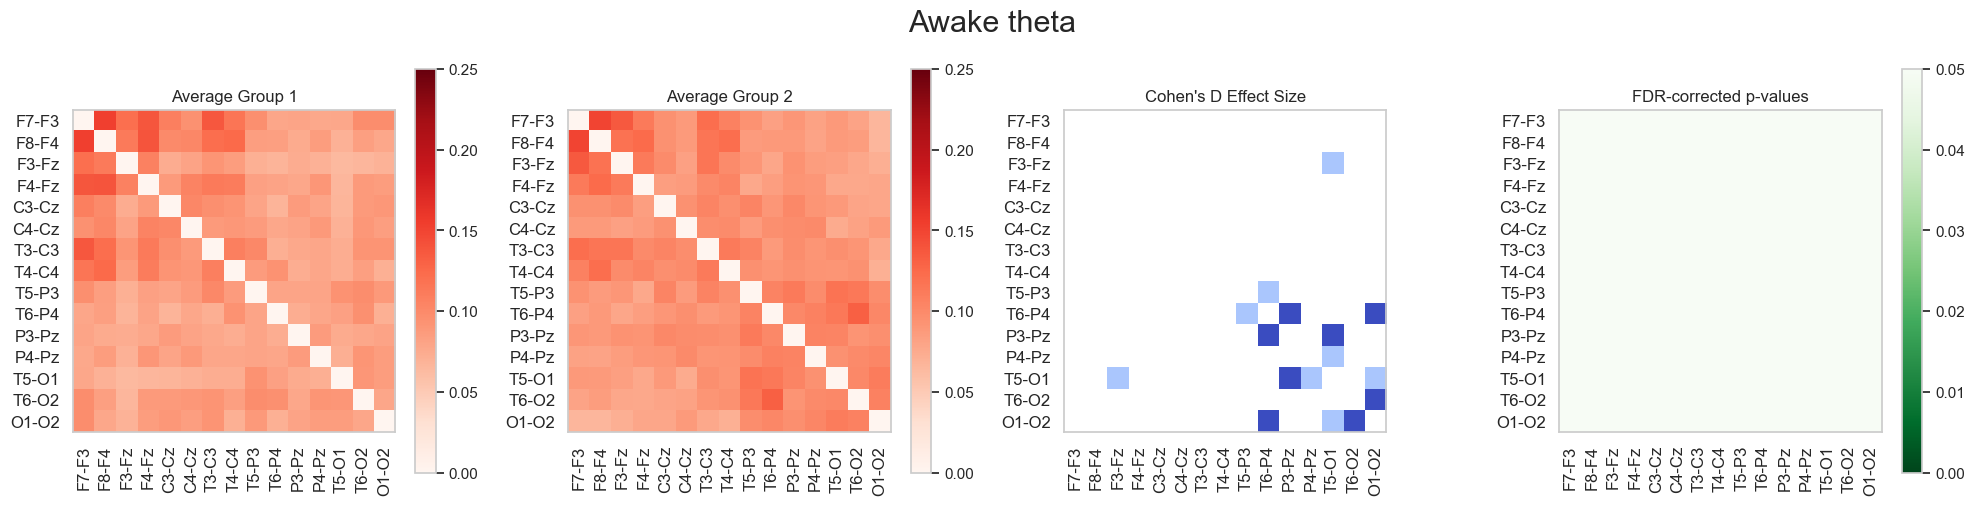

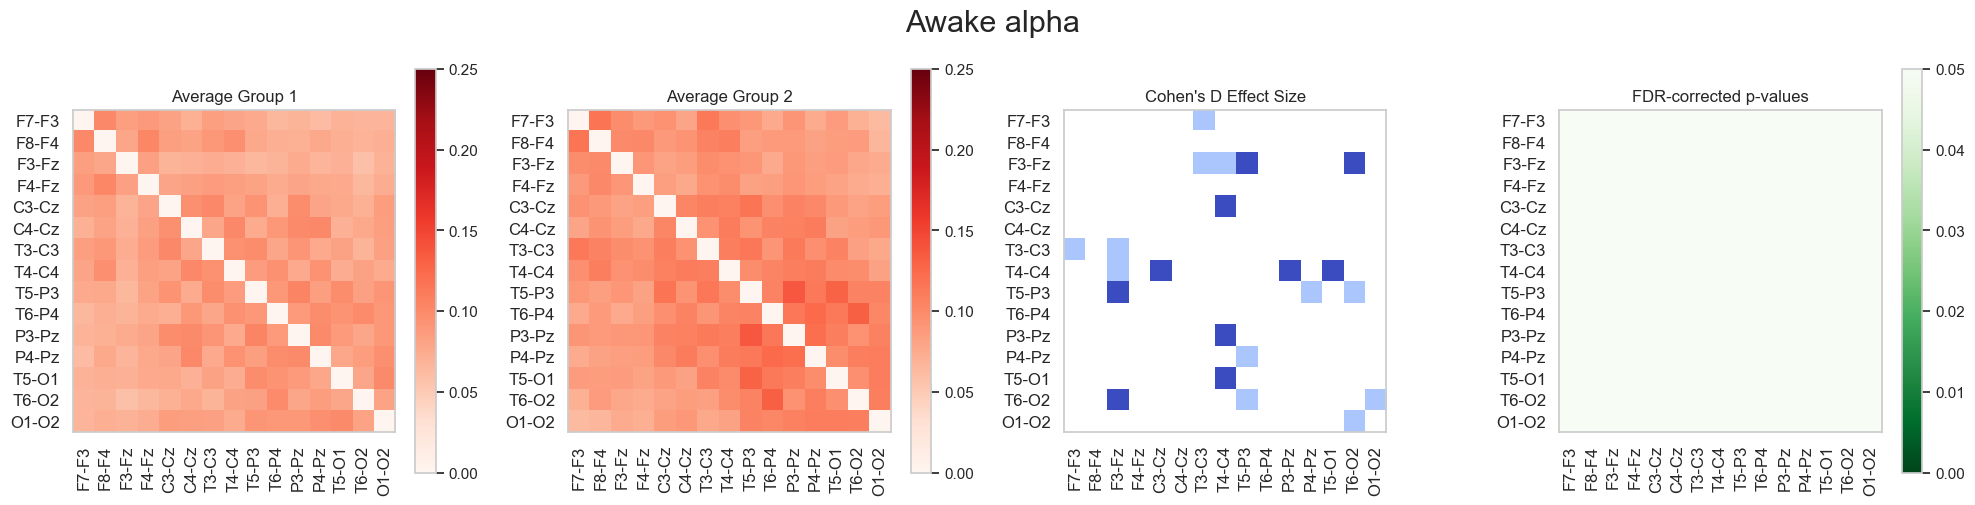

In [10]:
# Compare AD-Ep vs HC with the AD-Ep > HC contrast
cohens_d_channels_w_pval(adep_aec, hc_aec, channels, threshold_1=0.7, threshold_2=0.8, excluded_awake_channels=[0,1,2], excluded_keys=["4_beta", "4_gamma"])

In [11]:
# Analyze second night effects
# Merge 1st night and 2nd night feature tables

df_N2_gamma = features['1_gamma'].merge(second_night['1_gamma'], on = 'ID')
df_N2_delta = features['1_delta'].merge(second_night['1_delta'], on = 'ID')
df_N2_alpha = features['1_alpha'].merge(second_night['1_alpha'], on = 'ID')
df_REM_alpha = features['3_alpha'].merge(second_night['3_alpha'], on = 'ID')
df_REM_delta = features['3_delta'].merge(second_night['3_delta'], on = 'ID')
df_REM_beta = features['3_beta'].merge(second_night['3_beta'], on = 'ID')

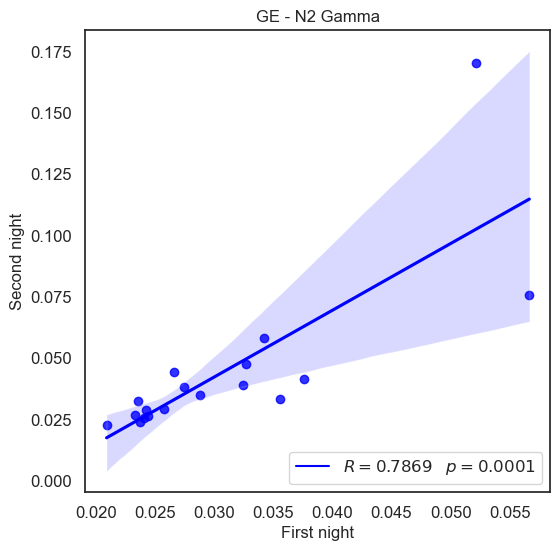

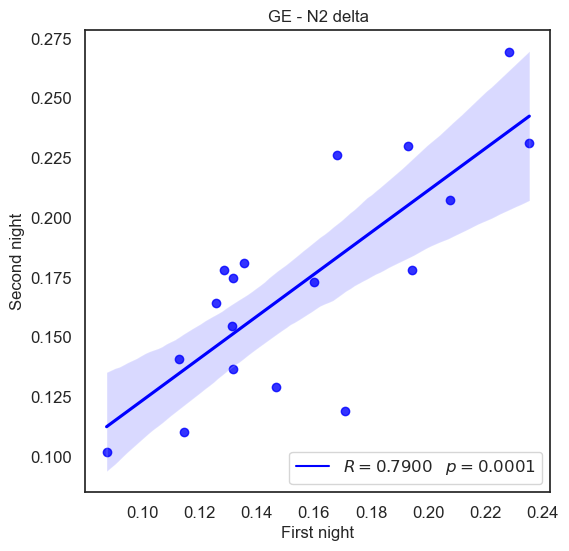

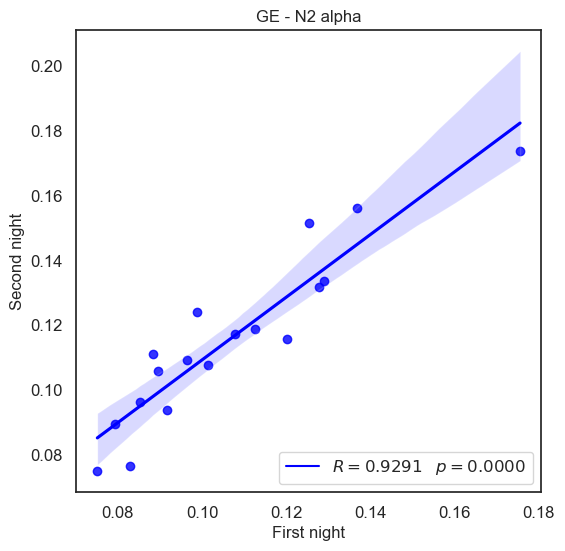

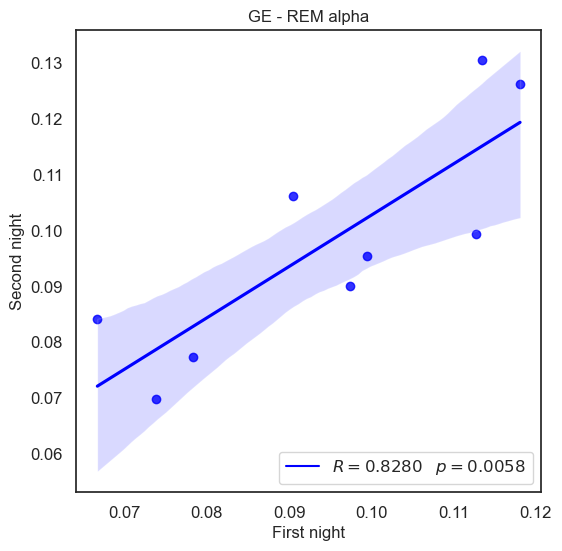

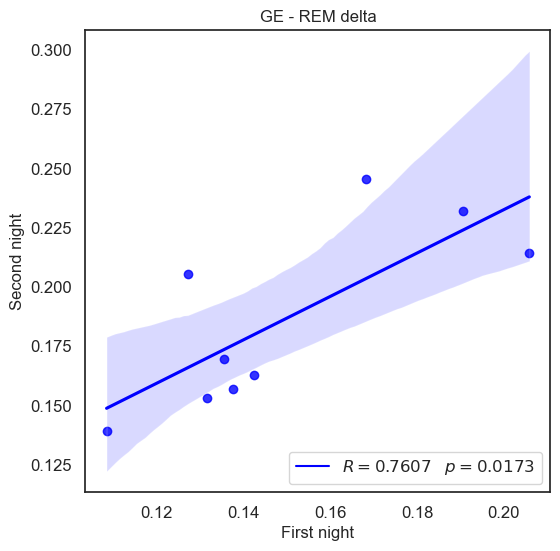

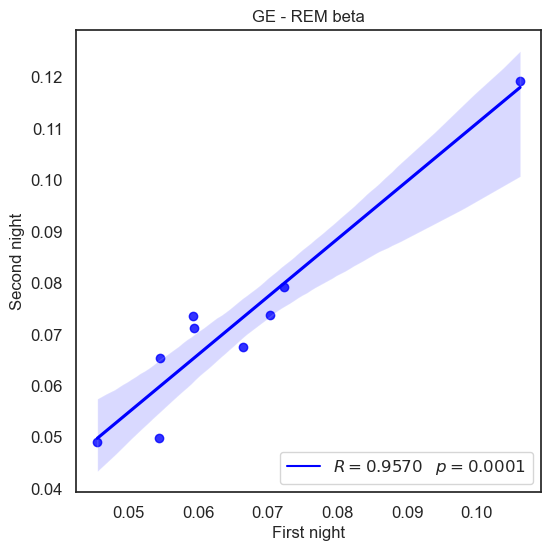

In [12]:
# Plot the regressions for the desired stages and bands
# Input should be the merged table, the features for the first night (suffix _x) and second night (suffix_y),
# and the title of the plot

plot_1st_vs_2nd_night(df_N2_gamma, "GE_AEC_x", "GE_AEC_y", "GE - N2 Gamma")
plot_1st_vs_2nd_night(df_N2_delta, "GE_AEC_x", "GE_AEC_y", "GE - N2 delta")
plot_1st_vs_2nd_night(df_N2_alpha, "GE_AEC_x", "GE_AEC_y", "GE - N2 alpha")
plot_1st_vs_2nd_night(df_REM_alpha, "GE_AEC_x", "GE_AEC_y", "GE - REM alpha")
plot_1st_vs_2nd_night(df_REM_delta, "GE_AEC_x", "GE_AEC_y", "GE - REM delta")
plot_1st_vs_2nd_night(df_REM_beta, "GE_AEC_x", "GE_AEC_y", "GE - REM beta")

In [13]:
#### Medication effects in Gamma in ADNoEp vs HC

AChEI_or_mem_gamma = ['ADEX_013',
                    'ADEX_014',
                    'ADEX_019',
                    'ADEX_026',
                    'ADEX_043',
                    'ADEX_065',
                    'ADEX_066',
                    'ADEX_073',
                    'ADEX_078',
                    'ADEX_088',
                    'ADEX_092',
                    'ADEX_102',
                    'ADEX_107',
                    'ADEX_117',
                    'ADEX_119',
                    'ADEX_137']

memantine_gamma = ['ADEX_013',
                    'ADEX_014',
                    'ADEX_019',
                    'ADEX_043',
                    'ADEX_073',
                    'ADEX_088',
                    'ADEX_102',
                    'ADEX_119',
                    'ADEX_137']

memantine_only_gamma = ['ADEX_137']

AChEI_gamma = ['ADEX_013',
                'ADEX_014',
                'ADEX_019',
                'ADEX_026',
                'ADEX_043',
                'ADEX_065',
                'ADEX_066',
                'ADEX_073',
                'ADEX_078',
                'ADEX_088',
                'ADEX_092',
                'ADEX_102',
                'ADEX_107',
                'ADEX_117',
                'ADEX_119']

AChEI_only_gamma = ['ADEX_026',
                    'ADEX_065',
                    'ADEX_066',
                    'ADEX_078',
                    'ADEX_092',
                    'ADEX_107']

nomedication_gamma = ['ADEX_005',
                    'ADEX_018',
                    'ADEX_025',
                    'ADEX_031',
                    'ADEX_042',
                    'ADEX_048',
                    'ADEX_054',
                    'ADEX_055',
                    'ADEX_058',
                    'ADEX_063',
                    'ADEX_068',
                    'ADEX_076',
                    'ADEX_079',
                    'ADEX_080',
                    'ADEX_084',
                    'ADEX_099',
                    'ADEX_103',
                    'ADEX_113',
                    'ADEX_116',
                    'ADEX_120',
                    'ADEX_125',
                    'ADEX_130',
                    'ADEX_132',
                    'ADEX_135',
                    'ADEX_136',
                    'ADEX_138',
                    'ADEX_140']

In [14]:
# Process N2 gamma data to pass to the plotting function
# Get N2 gamma features
df_gamma = features['1_gamma']

# Create a new column "Medication" with default value NaN
df_gamma["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_gamma.loc[df_gamma["ID"].isin(AChEI_or_mem_gamma), "Medication"] = 1
df_gamma.loc[df_gamma["ID"].isin(nomedication_gamma), "Medication"] = 0

# Select the desired columns, filtering the rest of the unused features
filtered_df_gamma = df_gamma[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Function to create a new target class whether medication is 1 or 0
def create_new_class(row):
    if row['Class'] == 'ADNoEp':
        if row['Medication'] == 1:
            return 'ADNoEp_medication'
        else:
            return 'ADNoEp_no_medication'
    return row['Class']

# Apply the function to create the new class column
filtered_df_gamma['Class'] = filtered_df_gamma.apply(create_new_class, axis=1)
filtered_df_gamma

Class        ID    GE_AEC  Medication
0      ADNoEp_medication  ADEX_026  0.052161         1.0
1   ADNoEp_no_medication  ADEX_138  0.033847         0.0
2      ADNoEp_medication  ADEX_019  0.034233         1.0
3      ADNoEp_medication  ADEX_073  0.029915         1.0
4      ADNoEp_medication  ADEX_102  0.060643         1.0
..                   ...       ...       ...         ...
84                    HC  ADEX_087  0.027429         NaN
85                    HC  ADEX_101  0.025684         NaN
86                    HC  ADEX_070  0.031094         NaN
87                    HC  ADEX_020  0.056645         NaN
88                    HC  ADEX_056  0.028760         NaN

[89 rows x 4 columns]

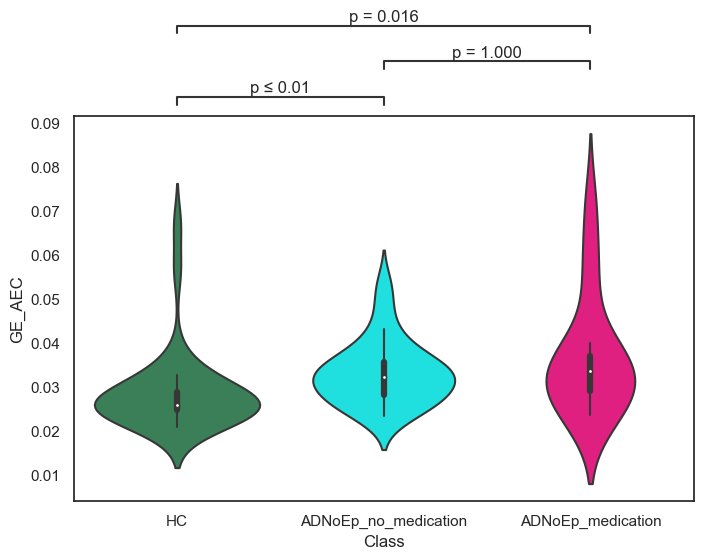

In [15]:
plot_med_effects(filtered_df_gamma, 'HC', 'ADNoEp_no_medication', 'ADNoEp_medication', metric='GE_AEC', colors = ["#2E8B57", "#00ffff", "#ff0080"])

In [16]:
# Same with N2 delta in ADEp vs ADNoEp
levetiracetam = ['ADEX_010',
                'ADEX_129',
                'ADEX_139']

no_levetiratecam = ['ADEX_001',
                    'ADEX_040',
                    'ADEX_044',
                    'ADEX_097',
                    'ADEX_100',
                    'ADEX_104',
                    'ADEX_114',
                    'ADEX_118',
                    'ADEX_126',
                    'ADEX_127',
                    'ADEX_128']

AEDs = ['ADEX_001',
        'ADEX_010',
        'ADEX_040',
        'ADEX_097',
        'ADEX_104',
        'ADEX_114',
        'ADEX_118',
        'ADEX_127',
        'ADEX_128',
        'ADEX_129',
        'ADEX_139']

no_AEDs = ['ADEX_044',
            'ADEX_100',
            'ADEX_126']

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
# Here we want to check the effects of Levetiracetam
df_delta.loc[df_delta["ID"].isin(levetiracetam), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_levetiratecam), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if row['Class'] == 'ADEp':
        if row['Medication'] == 1:
            return 'ADEp_medication'
        else:
            return 'ADEp_no_medication'
    return row['Class']

# Apply the function to create the new class column
filtered_df_delta['Class'] = filtered_df_delta.apply(create_new_class_delta, axis=1)
filtered_df_delta

Class        ID    GE_AEC  Medication
0   ADNoEp  ADEX_026  0.128770         NaN
1   ADNoEp  ADEX_138  0.157520         NaN
2   ADNoEp  ADEX_019  0.170782         NaN
3   ADNoEp  ADEX_073  0.098449         NaN
4   ADNoEp  ADEX_102  0.150391         NaN
..     ...       ...       ...         ...
84      HC  ADEX_087  0.135703         NaN
85      HC  ADEX_101  0.100032         NaN
86      HC  ADEX_070  0.141576         NaN
87      HC  ADEX_020  0.113023         NaN
88      HC  ADEX_056  0.161463         NaN

[89 rows x 4 columns]

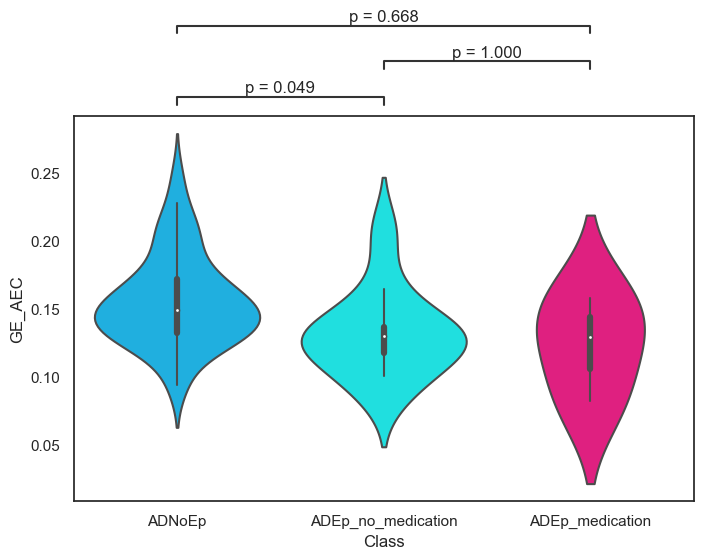

In [17]:
plot_med_effects(filtered_df_delta, 'ADNoEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])

In [18]:
### Compare med and no_med groups with all the group of the same class (e.g., ADEp)

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_delta.loc[df_delta["ID"].isin(AEDs), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_AEDs), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Duplicate the rows of 'ADEp' class and then modify the Class column
ADEp_rows = filtered_df_delta[filtered_df_delta["Class"] == "ADEp"].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if pd.isna(row['Medication']):
        return 'ADEp'
    elif row['Medication'] == 1:
        return 'ADEp_medication'
    else:
        return 'ADEp_no_medication'

# Apply the function to create the new class column only for ADEp_rows
ADEp_rows['Class'] = ADEp_rows.apply(create_new_class_delta, axis=1)

# Concatenate the modified ADEp_rows with the original dataframe
filtered_df_delta = pd.concat([filtered_df_delta, ADEp_rows], ignore_index=True)
filtered_df_delta

Class        ID    GE_AEC  Medication
0             ADNoEp  ADEX_026  0.128770         NaN
1             ADNoEp  ADEX_138  0.157520         NaN
2             ADNoEp  ADEX_019  0.170782         NaN
3             ADNoEp  ADEX_073  0.098449         NaN
4             ADNoEp  ADEX_102  0.150391         NaN
..               ...       ...       ...         ...
98   ADEp_medication  ADEX_127  0.110999         1.0
99   ADEp_medication  ADEX_104  0.164888         1.0
100  ADEp_medication  ADEX_128  0.125499         1.0
101  ADEp_medication  ADEX_118  0.088268         1.0
102  ADEp_medication  ADEX_139  0.082606         1.0

[103 rows x 4 columns]

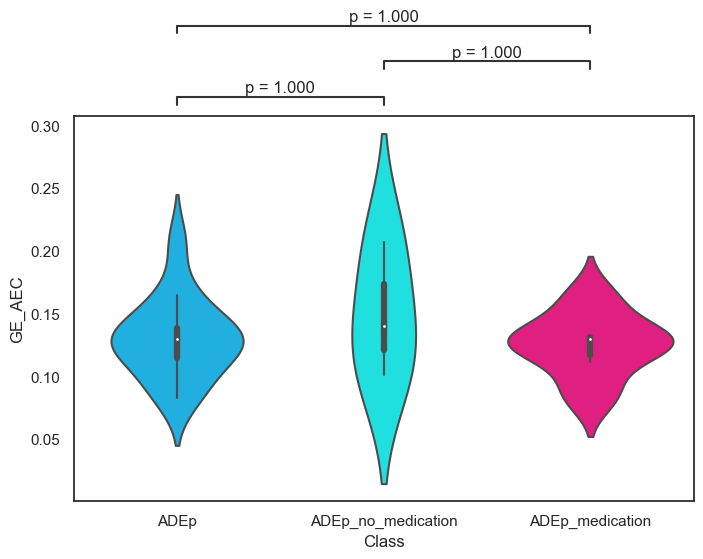

In [19]:
# Now compare all ADEp vs the ADEp no_med and ADEp med (considering AEDs in general)
plot_med_effects(filtered_df_delta, 'ADEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])

In [20]:
### Levetiracetam only
### Compare med and no_med groups with all the group of the same class (e.g., ADEp)

df_delta = features['1_delta']

# Create a new column "Medication" with default value NaN
df_delta["Medication"] = np.nan

# Update the "Medication" column based on the medication and non-medication lists
df_delta.loc[df_delta["ID"].isin(levetiracetam), "Medication"] = 1
df_delta.loc[df_delta["ID"].isin(no_levetiratecam), "Medication"] = 0

# Select the desired columns
filtered_df_delta = df_delta[["Class", "ID", "GE_AEC", "Medication"]].copy()

# Duplicate the rows of 'ADEp' class and then modify the Class column
ADEp_rows = filtered_df_delta[filtered_df_delta["Class"] == "ADEp"].copy()

# Function to create the new class based on Medication value
def create_new_class_delta(row):
    if pd.isna(row['Medication']):
        return 'ADEp'
    elif row['Medication'] == 1:
        return 'ADEp_medication'
    else:
        return 'ADEp_no_medication'

# Apply the function to create the new class column only for ADEp_rows
ADEp_rows['Class'] = ADEp_rows.apply(create_new_class_delta, axis=1)

# Concatenate the modified ADEp_rows with the original dataframe
filtered_df_delta = pd.concat([filtered_df_delta, ADEp_rows], ignore_index=True)
filtered_df_delta

Class        ID    GE_AEC  Medication
0                ADNoEp  ADEX_026  0.128770         NaN
1                ADNoEp  ADEX_138  0.157520         NaN
2                ADNoEp  ADEX_019  0.170782         NaN
3                ADNoEp  ADEX_073  0.098449         NaN
4                ADNoEp  ADEX_102  0.150391         NaN
..                  ...       ...       ...         ...
98   ADEp_no_medication  ADEX_127  0.110999         0.0
99   ADEp_no_medication  ADEX_104  0.164888         0.0
100  ADEp_no_medication  ADEX_128  0.125499         0.0
101  ADEp_no_medication  ADEX_118  0.088268         0.0
102     ADEp_medication  ADEX_139  0.082606         1.0

[103 rows x 4 columns]

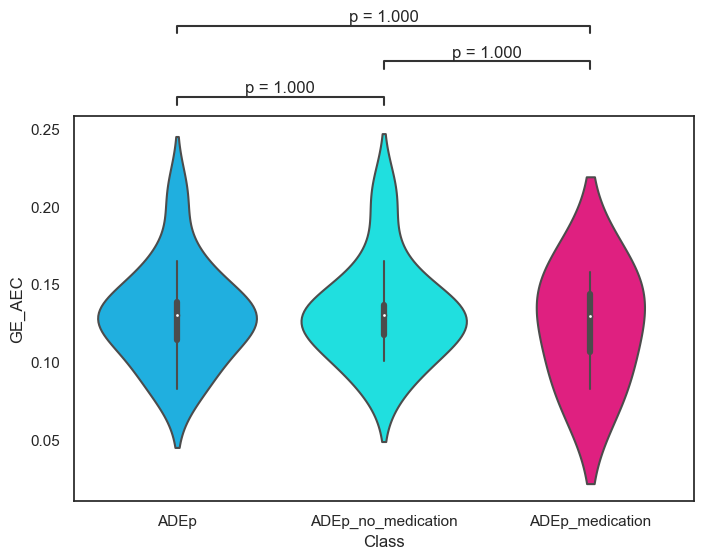

In [21]:
# Now compare all ADEp vs the ADEp no_med and ADEp med
plot_med_effects(filtered_df_delta, 'ADEp', 'ADEp_no_medication', 'ADEp_medication', metric='GE_AEC', colors = ["#00bfff", "#00ffff", "#ff0080"])